In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Amazon Fine Food Reviews Analysis using Support Vector Machines.

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

#### Basic information about the downloaded dataset<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Our main objective for this analysis is to train a model which can seperate the postive and negative reviews.
In this problem we will apply classification techniques called Support Vector Machines to get an idea if the data can be seperated based on its polarity, i.e. if the review is positive or negative. By looking at the Score column we can make out that the review is positive or not. But we don't need to implement any ML here. A simple if-else condition will make us do this. So for this problem, we will put our focus on to the Review text. The text is the most important feature here if you may ask. Based on the review text we will build a prediction model and determine if a future review is positive or negative.

#### While pre-processing the original dataset we have taken into consideration the following points.

1. We will classify a review to be positive if and only if the corresponding Score for the given review is 4 or 5.
2. We will classify a review to be negative if and only if the corresponding Score for the given review is 1 or 2.
3. We will ignore the reviews for the time being which has a Score rating of 3. Because 3 can be thought of as a neutral review. It's neither negative nor positive.
4. We will remove the duplicate entries from the dataset. 
5. We will train our final mdel using four featurizations -> bag of words model, tf-idf model, average word-to-vec model and tf-idf weighted word-to-vec model.
6. So at end of the training the model will be trained on the above four featurizations to determine if a given review is positive or negative (Determining the sentiment polarity of the Amazon reviews)

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.calibration import CalibratedClassifierCV

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [31]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('database.sqlite') 

#Filter only positive and negative reviews. Do not consider reviews with score = 3.
#not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, connection_sqlobject)

#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

#Display some of the datapoints from the loaded dataset.
print("Number of data points in our data", filtered_data.shape[0])
print("Number of features in our data", filtered_data.shape[1])
filtered_data.head(5)

Number of data points in our data 525814
Number of features in our data 12


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [32]:
#This code block check how many entries are there from the same user id, who has provided review more than one time for different products.
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", connection_sqlobject)

print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [33]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [34]:
display['COUNT(*)'].sum()

393063

In [35]:
#Checking the number of entries that came from UserId="AR5J8UI46CURR"
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", connection_sqlobject)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [36]:
#Display information about the dataset before the removal of duplicate data.
print("The shape of the filtered matrix : {}".format(filtered_data.shape))
print("The median score values : {}".format(filtered_data['Score'].mean()))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

The shape of the filtered matrix : (525814, 12)
The median score values : 4.27914813983652
The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative     82037
Name: SentimentPolarity, dtype: int64


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [37]:
#Sorting data according to Time in ascending order. The oldest reviews will be displayed at the top and the new reviews will be display at the end of the dataset.
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

In [38]:
#Removing duplicate entries based on past knowledge.
filtered_duplicates=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print("The shape of the data matrix after deduplication, Stage 1: {}".format(filtered_duplicates.shape))

The shape of the data matrix after deduplication, Stage 1: (364173, 12)


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calculations

In [39]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", connection_sqlobject)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [40]:
#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
final_data=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

In [41]:
#Display information about the dataset after the removal of duplicate data.
print("\nThe shape of the data matrix after deduplication, Stage 2: : {}".format(final_data.shape))
print("The median score values after deduplication : {}".format(final_data['Score'].mean()))
print("The number of positive and negative reviews after the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())

#Checking to see how much % of data still remains.
print("\nChecking to see how much percentage of data still remains.")
retained_per = (final_data['SentimentPolarity'].size*1.0)/(filtered_data['SentimentPolarity'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))

#Delete unwanted variables to free up memory space
del(filtered_duplicates, filtered_data, display, sorted_data)

#Display the first 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.
print("\nFirst 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.")
final_data.head(5)


The shape of the data matrix after deduplication, Stage 2: : (364171, 12)
The median score values after deduplication : 4.27579626054793
The number of positive and negative reviews after the removal of duplicate data.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64

Checking to see how much percentage of data still remains.
Percentage of redundant data removed : 30.741478926008057
Percentage of original data retained : 69.25852107399194

First 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
122486,132756,B000O3KMKG,AAB6ZMWFCK4GO,Bill Gary,0,0,5,1351209600,Excellent,The Premium Bourbon Madagascar Vanilla Vannila...,Positive,1
435165,470583,B001LUM1ZU,A3HJN5HU71FQIT,muxicboxsuprhero,0,0,1,1351209600,God Awful,As a dabbler who enjoys spanning the entire sp...,Negative,0
279857,303246,B0002DGRZC,AUINI96NMGXUI,Kkrys23,0,0,5,1351209600,Love this faucet,Love this faucet. My husband had installed th...,Positive,1
279856,303245,B0002DGRZC,A3SSEJ8IEM4YGW,Seagaul,0,0,5,1351209600,Dogs love it.,"This is the ""all gone"" treat after dinner. It...",Positive,1
466254,504114,B001M0AKE8,A07112861KSNE1D0ZA1NO,Canon Fan,0,0,4,1351209600,Quaker Instant Oatmeal Dinosaur Eggs,This has been a firm favorite at breakfast tim...,Positive,1


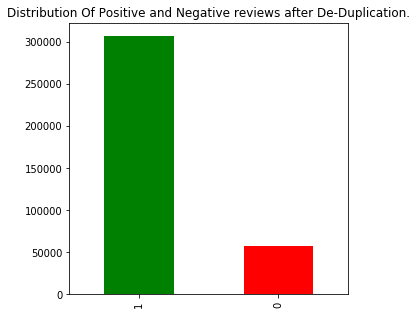

In [42]:
#Display distribution of Postive and Negative reviews in a bar graph
final_data["Class_Labels"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews after De-Duplication.',figsize=(5,5))

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [43]:
#Printing some random reviews from the deduplicated dataset.
sent_1 = final_data['Text'].values[0]
print(sent_1)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[0]))
print("="*215)

sent_2 = final_data['Text'].values[1000]
print(sent_2)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1000]))
print("="*215)

sent_3 = final_data['Text'].values[1500]
print(sent_3)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1500]))
print("="*215)

sent_4 = final_data['Text'].values[4900]
print(sent_4)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[4900]))
print("="*215)

sent_5 = final_data['Text'].values[12566]
print(sent_5)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[12566]))
print("="*215)

sent_6 = final_data['Text'].values[255600]
print(sent_6)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[255600]))
print("="*215)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.
Review Polarity: Positive
I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal.
Review Polarity: Positive
This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.<br /><br />Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again.
Review Polarity: Positive
At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My d

In [44]:
#Remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_1 = re.sub(r"http\S+", " ", sent_1)
sent_2 = re.sub(r"http\S+", " ", sent_2)
sent_3 = re.sub(r"http\S+", " ", sent_3)
sent_4 = re.sub(r"http\S+", " ", sent_4)
sent_5 = re.sub(r"http\S+", " ", sent_5)
sent_6 = re.sub(r"http\S+", " ", sent_6)

print(sent_1,"\n")
print("="*215)
print(sent_2,"\n")
print("="*215)
print(sent_3,"\n")
print("="*215)
print(sent_4,"\n")
print("="*215)
print(sent_5,"\n")
print("="*215)
print(sent_6,"\n")
print("="*215)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful. 

I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal. 

This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.<br /><br />Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again. 

At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My daughter also had the same results. 

Excellent service, the product arri

In [45]:
#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text


print(removeHtml(sent_1) + "\n")
print(removeHtml(sent_2) + "\n")
print(removeHtml(sent_3) + "\n")
print(removeHtml(sent_4) + "\n")
print(removeHtml(sent_5) + "\n")
print(removeHtml(sent_6) + "\n")

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.

I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal.

This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.  Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again.

At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My daughter also had the same results.

Excellent service, the product arrived on time an

In [46]:
# https://stackoverflow.com/a/47091490/4084039
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
import re

#Expand the reviews x is aninput string of any length. Convert all the words to lower case
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

In [47]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
'''
>>> import re
>>> s = "ABCD abcd AB55 55CD A55D 5555"
>>> re.sub("\S*\d\S*", "", s).strip()

'ABCD abcd'
>>>'''

sent_1 = re.sub("\S*\d\S*", " ", sent_1).strip()
print(sent_1)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.


In [73]:
'''Data Cleaning Stage. Clean each review from the sampled Amazon Dataset.'''
#Data Cleaning Stage. Clean each review from the sampled Amazon Dataset

''' pattern = re.compile('<.*?>') #Function to clean html tags from a sentence
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text'''

#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def removeNumbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return (sentence)

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Remove URL from sentences.
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)
    
#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc. https://stackoverflow.com/a/5843547/4084039
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return (cleaned_text)

#https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
#Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

In [49]:
#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['no', 'nor', 'not'])
custom_stopwords = default_stopwords - remove_not

<h2><font color='red'>[3.1] Preprocessing Review Text</font></h2>

100%|██████████| 70246/70246 [00:00<00:00, 797137.23it/s]


Text(0,0.5,'Number of Words')

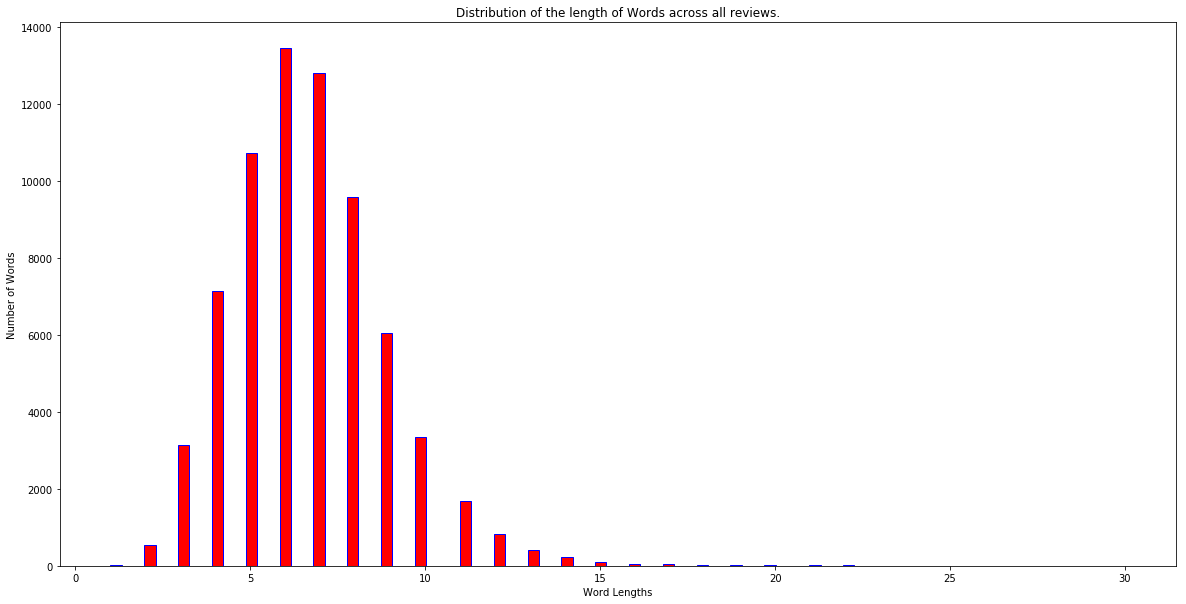

In [71]:
#We will check the distribution of stemmed word lengths across the whole review dataset to understand what is the length of the maximum number of words we will consider for the word to be relevant.
#In other words we will keep only those words which has a length less than that of a speicific length (we will obtain this specific length from the histogram).
total_words = []

for review in tqdm(final_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords)):          
            stemed_word=(sno.stem(cleaned_words.lower()))
            total_words.append(stemed_word)

total_words = list(set(total_words)) #Get list of unique words.

#A list to hold the length of each words used in all the reviews used across the whole dataset.
dist = []
for i in tqdm(total_words):
    length = len(i)
    dist.append(length)

# matplotlib histogram to see the distribution of the length of words
plt.figure(figsize=(20,10))
plt.hist(dist, color = 'red', edgecolor = 'blue', bins =90)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

### Conclusion from the above histogram:
We can see that most stemmed words present in the reviews has lengths between 4 and 10. Words which has length greater than 15 are very very very few as compared to other words. So we will discard these words from the reviews when we process them. It means we will consider only those words whose length is greater than 2 and less than 16.

In [74]:
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
 
count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
stemed_word=' '

for review in tqdm(final_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(sno.stem(cleaned_words.lower()))                                   
            filtered_sentence.append(stemed_word)
            if (final_data['SentimentPolarity'].values)[count] == 'Positive': 
                all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
            if(final_data['SentimentPolarity'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
#Save the list of positive words and negative words
import pickle
with open('all_positive_words.pkl', 'wb') as file:
    pickle.dump(all_positive_words, file)
    
with open('all_negative_words.pkl', 'wb') as file:
    pickle.dump(all_negative_words, file)
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))

#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews

100%|██████████| 364171/364171 [11:37<00:00, 521.74it/s]


The length of the data corpus is : 364171


<h2><font color='red'>[3.2] Preprocessing Review Summary + Saving the Processed DB for future use.</font></h2>

In [79]:
## Similartly you can do preprocessing for summary summary also.
import warnings
warnings.filterwarnings("ignore")

preprocessed_summary = [] #Store all the processed summary
 
count=0     #Iterator to iterate through the list of summarys and check if a given summary belongs to the positive or negative class
string=' '    
stemed_word=' '

for summary in tqdm(final_data['Summary'].values):
    filtered_sentence=[]
    summary = decontracted(summary)
    summary = removeNumbers(summary)
    summary = removeHtml(summary)
    summary = removeURL(summary)
    summary = removePunctuations(summary)
    summary = removePatterns(summary)
    
    for cleaned_words in summary.split():
        if(2<len(cleaned_words)<16):
            stemed_word=(sno.stem(cleaned_words.lower()))
            filtered_sentence.append(stemed_word)
    summary = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_summary.append(summary.strip()) #Data corpus contaning cleaned summarys from the whole dataset
    count+=1
    
#Adding a column of CleanedSummary to the table final which stores the data_corpus after pre-processing the summarys 
final_data['CleanedSummary']=preprocessed_summary

#Combing the reviews with summary for each sentence
final_data['Combined_Reviews'] = final_data['CleanedText'].values + " " + final_data['CleanedSummary'].values 

#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
final_data.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True)

print("File is saved as 'totally_processed_DB.sqlite'")

File is saved as 'totally_processed_DB.sqlite'


# [4] Featurization

In [4]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite') 
processed_db = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data into train and test set. The train set will contain 100K old reviews. The test set has 30k newer reviews. We will also use 40K latest reviews as a calibration dataset to calibrate our model. 
X_train = processed_db['Combined_Reviews'].iloc[150000:250000,] ; y_train = processed_db['Class_Labels'].iloc[150000:250000,]
X_test = processed_db['Combined_Reviews'].iloc[250000:280000,] ; y_test = processed_db['Class_Labels'].iloc[250000:280000,]
X_calib = processed_db['Combined_Reviews'].iloc[280000:320000,] ; y_calib = processed_db['Class_Labels'].iloc[280000:320000,]

processed_db.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels,CleanedText,CleanedSummary,Combined_Reviews
0,122486,132756,B000O3KMKG,AAB6ZMWFCK4GO,Bill Gary,0,0,5,1351209600,Excellent,The Premium Bourbon Madagascar Vanilla Vannila...,Positive,1,premium bourbon madagascar vanilla vannila bea...,excel,premium bourbon madagascar vanilla vannila bea...
1,435165,470583,B001LUM1ZU,A3HJN5HU71FQIT,muxicboxsuprhero,0,0,1,1351209600,God Awful,As a dabbler who enjoys spanning the entire sp...,Negative,0,dabbler enjoy span entir spectrum tast will tr...,god aw,dabbler enjoy span entir spectrum tast will tr...
2,279857,303246,B0002DGRZC,AUINI96NMGXUI,Kkrys23,0,0,5,1351209600,Love this faucet,Love this faucet. My husband had installed th...,Positive,1,love faucet husband instal one old hous curren...,love this faucet,love faucet husband instal one old hous curren...
3,279856,303245,B0002DGRZC,A3SSEJ8IEM4YGW,Seagaul,0,0,5,1351209600,Dogs love it.,"This is the ""all gone"" treat after dinner. It...",Positive,1,gone treat dinner treat dog work run chanc los...,dog love,gone treat dinner treat dog work run chanc los...
4,466254,504114,B001M0AKE8,A07112861KSNE1D0ZA1NO,Canon Fan,0,0,4,1351209600,Quaker Instant Oatmeal Dinosaur Eggs,This has been a firm favorite at breakfast tim...,Positive,1,firm favorit breakfast time hous mani year pic...,quaker instant oatmeal dinosaur egg,firm favorit breakfast time hous mani year pic...


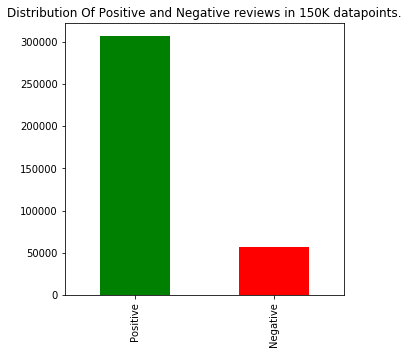

In [5]:
#Display distribution of Postive and Negative reviews.
processed_db["SentimentPolarity"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews in 150K datapoints.',figsize=(5,5))

## [4.1] BAG OF WORDS

A bag-of-words model, or BoW for short, is a way of extracting features from text for use in modeling, such as with machine learning algorithms.
The approach is very simple and flexible, and can be used in a myriad of ways for extracting features from documents. Suppose we have N reviews in our dataset and we want to convert the words in our reviews to vectors. We can use BOW as a method to do this. What it does is that for each unique word in the data corpus, it creates a dimension. Then it counts how many number of times a word is present in a review. And then this number is placed under that word for a corresponding review. We will get a Sparse Matrix representation for all the worods inthe review.

Let's look at this example of 2 reviews below :

r1 = {"The food is great, ambience is great"} and  </br>r2 = {"I love this food"}

At first the words will be extracted from r1 and r2.

r1' = {"The", "food", "is", "great", "ambience", "is", "great"} and r2' = {"I", "love", "this", "food"}

Now using r1' and r2' we will create a vector of unique words -> V =  {"The", "food", "is", "great", "ambience", "I", "love", "this"}

Now here's how the vector representation will look like for each reviews r1 and r2, when we make use of the vector 'V' created above.

r1_vector = [1,1,2,2,1,0,0,0] and r2_vector = [0,1,0,0,0,1,1,1]

In r1 since, "great" and "is" occurs twice, we have set the count to 2. If a words doesn't occur in a review we will set the count to 0. Although "is" a stopword, the example above is intended to make you understand how bag of words work.



In [6]:
#Initializing the BOW constructor
cv_object = CountVectorizer(min_df=10, max_features=50000, dtype='float')
cv_object.fit(X_train)

#Print names of some random features
print("Some feature names ", cv_object.get_feature_names()[100:110])
print('='*215)

#Creating the BOW matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus...")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)
X_calib_vectors = cv_object.transform(X_calib)

print("\nThe type of count vectorizer ",type(X_train_vectors))
print("The shape of our train BOW vectorizer ",X_train_vectors.get_shape())
print("The shape of our test BOW vectorizer ",X_test_vectors.get_shape())
print("The number of unique words ", X_train_vectors.get_shape()[1])

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_BOW.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)

with open('y_train_BOW.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('X_test_BOW.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_test_BOW.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_BOW.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_BOW.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

Some feature names  ['aesthet', 'affair', 'affect', 'affili', 'afford', 'afghanistan', 'aficionado', 'aforement', 'afraid', 'africa']

Creating the BOW vectors using the cleaned corpus...

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our train BOW vectorizer  (100000, 8750)
The shape of our test BOW vectorizer  (30000, 8750)
The number of unique words  8750


## [4.2] TF-IDF

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

Let's assume we have data corpus D, which contains N reviews {r1,r2,r3,r4...rN}. Let's say our review r1 contains the following words {w1,w2,w3,w1,w9,w6,w7,w9,w9}.

TF or Term Frequency for a word is basically the number of times a word occurs in a review divided by the total number of words present in that same review.
For example, in the text corpus that we have considered in the above example, the TF for word w1 is (2/9) and for word w9 is (1/3). Intuitively, higher the occurence of a word in a text is, greater will be its TF value. TF values lies between 0 and 1.

IDF or Inverse Document Frequency for a word is given by the formula log(N/n), where 'N' is equal to the total number of reviews in the corpus 'D' and 'n' refers to the number of reviews in 'D' which contains that specific word. Intuitively, IDF will be higher for words which occur rarely and will be less for words which occurs more frequently. IDF values are more than 0.

So for each word in each review we will consider the product of (TF x IDF), and represent it in a d dimensional vector. 

TF-IDF basically doesn't consider the semantic meaning of words. But what is does is that it gives more importance to words which occurs less frequently in the whole data corpus and also gives much importance to the most frequent words that occurs in each review.

In [7]:
#Initializing the TF-IDF constructor
tf_idf_obj = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=50000, dtype='float').fit(X_train) #min_df=10: ignore terms that have a document frequency strictly lower than 10.
                                                                                                           #max_features=50000: top 50000 features
#Print names of some random features
print("Some feature names ", tf_idf_obj.get_feature_names()[100:110])
print('='*215)

#Creating the TF-IDF matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the TF-IDF vectors using the cleaned corpus...")
X_train_vectors = tf_idf_obj.transform(X_train)
X_test_vectors = tf_idf_obj.transform(X_test)
X_calib_vectors = tf_idf_obj.transform(X_calib)

print("\nThe type of count vectorizer ",type(X_train_vectors))
print("The shape of our train TFIDF Bi-Gram vectorizer ",X_train_vectors.get_shape())
print("The shape of our test TFIDF Bi-Gram vectorizer ",X_test_vectors.get_shape())
print("The number of unique words including both unigrams and bigrams. ", X_train_vectors.get_shape()[1])

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

Some feature names  ['accident', 'accident order', 'acclim', 'accommod', 'accompani', 'accomplish', 'accord', 'accord box', 'accord direct', 'accord instruct']

Creating the TF-IDF vectors using the cleaned corpus...

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our train TFIDF Bi-Gram vectorizer  (100000, 50000)
The shape of our test TFIDF Bi-Gram vectorizer  (30000, 50000)
The number of unique words including both unigrams and bigrams.  50000


## [4.3] Avg W2V

In this model we convert each word present in a review to vectors. For each sentence we will compute the average word to vec representation. Let's look at the below demo example.

Suppose we have N words in a sentence {w1,w2,w3,w4,w5,w6 ... , wN}. We will convert each word to a vector, sum them up and divide by the total number of words (N) present in that particular sentence. So our final vector will look like (1/N) * [word2vec(w1) + word2vec(w2) + word2vec(w3) .... + word2vec(wN)]

In [5]:
#Build a Word2Vec model on train data and use this to vectorize the test and cv data.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split()) #Returns a list of words for each sentence for all the reviews
print("The size of the Word2Vec text corpus : ",len(word2vec_corpus))

word2vec_model=Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=6) #min_count = 5 considers only those words for our model which occurs atleast 5 times
word2vec_words = list(word2vec_model.wv.vocab)                                       #print("\nThe number of words that occured minimum 5 times : ",len(word2vec_words))

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_w2v(dataset, word2vec_model, word2vec_words):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split()) 
    
    # Creating average Word2Vec model by computing the average word2vec for each review.
    sent_vectors = []; #The average word2vec for each sentence/review will be stored in this list
    for sentence in tqdm(word2vec_corpus): #For each review
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        count_words =0; #This will store the count of the words with a valid vector in each review text
        for word in sentence: #For each word in a given review.
            if word in word2vec_words:
                word_vectors = word2vec_model.wv[word] #Creating a vector(numpy array of 100 dimensions) for each word.
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    #print("\nThe length of the sentence vectors :",len(sent_vectors))
    #print("\nSize of each vector : ",len(sent_vectors[0]))
    sent_vectors = np.array(sent_vectors)
    return sent_vectors


X_train_vectors = vectorize_w2v(X_train, word2vec_model, word2vec_words)
X_test_vectors = vectorize_w2v(X_test, word2vec_model, word2vec_words)
X_calib_vectors = vectorize_w2v(X_calib, word2vec_model, word2vec_words)


print("The shape of our Avg Word2Vec train vectorizer ",X_train_vectors.shape)
print("The shape of our Avg Word2Vec test vectorizer ",X_test_vectors.shape)
print("The shape of our Avg Word2Vec calibration vectorizer ",X_calib_vectors.shape)

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_W2V.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_W2V.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_W2V.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_W2V.pkl', 'wb') as file:
    pickle.dump(y_test, file)

with open('X_calib_W2V.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_W2V.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

100%|██████████| 40000/40000 [01:23<00:00, 476.88it/s]


The shape of our Avg Word2Vec train vectorizer  (100000, 200)
The shape of our Avg Word2Vec test vectorizer  (30000, 200)
The shape of our Avg Word2Vec calibration vectorizer  (40000, 200)


## [4.4] TFIDF weighted W2v

In this model we convert each word present in a review to vectors. For each sentence we will compute the tf-idf average word to vec representation. Let's look at the below demo example.

Suppose we have N words in a sentence {w1,w2,w3,w4,w5,w6 ... , wN}. We will compute the tf-idf for each word in a review for all reviews. Lets say the corresponding tf-idfs are {t1,t2,t3,t4,t5,t6......tN}. We will convert each word to a vector, sum them up and divide by the summation of tf-idf vectors for all words present in that particular sentence. So our final vector will look like [1/(t1+t2+t3+t4+t5+t6+ ..... +tN)] * [word2vec(w1) + word2vec(w2) + word2vec(w3) .... + word2vec(wN)]

In [28]:
#Build a word2vec model using the train data and use this model to vectorize test and cv data.
#word2vec_corpus will store the list of words for each review.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split())

#min_count = 5 considers only those words which occurs atleast 5 times
word2vec_model=Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=8)
word2vec_words = list(word2vec_model.wv.vocab)

#Initializing the TF-IDF contructor with review texts. HTML tags and punctuations are removed. Stopwords are preserved.
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_tfidf_w2v(dataset, tf_idf_object, word2vec_model, word2vec_words):

    #word2vec_corpus will store the list of words for each review.
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split())

    #Use the earlier TF-IDF object to vectorize test and cv data.
    tf_idf_matrix = tf_idf_object.transform(dataset)
    tfidf_features = tf_idf_object.get_feature_names() 
    
    # We are building a dictionary with words as a key, and the idfs as value
    dictionary = dict(zip(tf_idf_object.get_feature_names(), list(tf_idf_object.idf_)))

    #Algorithm for finding the TF-IDF weighted average word2vec vectors.
    tfidf_sent_vectors = []; #The tfidf-w2v for each sentence/review will stored in this list
    row=0;
    for sentence in tqdm(word2vec_corpus): #For each review/sentence 
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        weight_sum = 0; #This will store the count of the words with a valid vector in each review text.
        for word in sentence: #For each word in a review/sentence
            if((word in word2vec_words) and (word in tfidf_features)):
                word_vectors = word2vec_model.wv[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence)) #tf_idf = tf_idf_matrix[row, tfidf_features.index(word)] #tf_idfidf of a word in a sentence/review       
                sent_vec += (word_vectors * tf_idf)                            #dictionary[word] = idf value of word in whole courpus  # sent.count(word) = tf valeus of word in this review                          
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    tfidf_sent_vectors = np.array(tfidf_sent_vectors)
    return tfidf_sent_vectors

#Converting the words to word vector representation.
X_train_vectors = vectorize_tfidf_w2v(X_train, tf_idf_object, word2vec_model, word2vec_words)
X_test_vectors = vectorize_tfidf_w2v(X_test, tf_idf_object, word2vec_model, word2vec_words)
X_calib_vectors = vectorize_tfidf_w2v(X_calib, tf_idf_object, word2vec_model, word2vec_words)

print("The shape of our TF-IDF Avg Word2Vec train vectorizer ",X_train_vectors.shape)
print("The shape of our TF-IDF Avg Word2Vec test vectorizer ",X_test_vectors.shape)
print("The shape of our TF-IDF Avg Word2Vec calibration vectorizer ",X_calib_vectors.shape)
                                           
#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

100%|██████████| 40000/40000 [28:44<00:00, 23.20it/s]  


The shape of our TF-IDF Avg Word2Vec train vectorizer  (100000, 200)
The shape of our TF-IDF Avg Word2Vec test vectorizer  (30000, 200)
The shape of our TF-IDF Avg Word2Vec calibration vectorizer  (40000, 200)


# [5] Task: Apply SGD Classifier with Hinge Loss


<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

The below block of code contains all the common functions that are used for the evaluation of the models.

In [10]:
#This function is used to standardize a data matrix.
def standardize(data, with_mean):
    '''Function used to column standardize any given matrix'''
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler(with_mean=with_mean)
    std=scalar.fit_transform(data)
    return (std)

#This function is used to plot the ROC curve on both train and test.
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc(classifier, X_train, y_train, X_test, y_test):
    from sklearn.metrics import roc_curve, auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    '''TEST DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    fpr["Test"], tpr["Test"], threshold = roc_curve(y_test, y_probs)
    roc_auc["Test"] = auc(fpr["Test"], tpr["Test"])
    
    '''TRAIN DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_train)
    y_probs = class_probabilities[:,1]
    fpr["Train"], tpr["Train"], threshold = roc_curve(y_train, y_probs)
    roc_auc["Train"] = auc(fpr["Train"], tpr["Train"])
    
    plt.figure(figsize=(15,10))
    linewidth = 2
    plt.plot(fpr["Test"], tpr["Test"], color='green', lw=linewidth, label='ROC curve Test Data (area = %0.2f)' % roc_auc["Test"])
    plt.plot(fpr["Train"], tpr["Train"], color='red', lw=linewidth, label='ROC curve Train Data (area = %0.2f)' % roc_auc["Train"])
    plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--', label='Baseline ROC curve (area = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

#This function is used to plot the performance of model both on train data and cross validation data for each hyper parameter.
def plot_errors(gsearch_cv, regularization, hyp):
    '''This function is used to plot the curve for mean squared errors vs alpha values and obtain the optimal 
    value of the hyperparameter'''
    
    #Get cross validation scores. Here we obtain the C values and their corresponding mean test scores.
    cv_result = gsearch_cv.cv_results_         
    auc_test = list(cv_result["mean_test_score"])        #list that will hold the mean of cross validation accuracy scores for each C
    auc_train = list(cv_result["mean_train_score"])
    hyperparameters = cv_result["params"]
    
    hp_values = []                         #list that will hold all the C or alpha values that the grid search cross validator tried.
    for i in range(0,len(hyperparameters)):
        hp_values.append(hyperparameters[i][hyp])
    
    '''#Changing accuracy to mean squared error. **error = 1 - accuracy ; error = Cross Validation Errors, accuracy = Cross Validation accuracy
    auc_test_error = [1 - x for x in auc_test]
    auc_train_error = [1 - x for x in auc_train]'''
    
    #Determining best alpha from errors. 'C' will be best for the lowest value for error
    optimal_hp = hp_values[auc_test.index(max(auc_test))] 
    print('The optimal value of C using l1 regularization is : {}'.format(optimal_hp))     
    
    #Plot error vs Hyperparameter values
    plt.figure(figsize=(35,8))
    plt.plot(hp_values , auc_train, color='red', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
    plt.plot(hp_values , auc_test, color='blue', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Validation AUC')
    plt.title('AUC Scores vs Hyperparameter Values ')
    plt.xlabel('Hyperparameter: Values of {}'.format(hyp))
    plt.ylabel('(AUC Scores)')
    plt.legend()
    plt.show()
    
    if(regularization=='l2'):
        #Plot error vs Hyperparameter values ====> ZOOMED IN PLOT
        plt.figure(figsize=(35,8))
        plt.plot(hp_values[0:40] , auc_train[0:40], color='red', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
        plt.plot(hp_values[0:40] , auc_test[0:40], color='blue', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Validation AUC')
        plt.title('AUC Scores vs Hyperparameter Values (ZOOMED IN PLOT) ')
        plt.xlabel('Hyperparameter: Values of {}'.format(hyp))
        plt.ylabel('(AUC Scores)')
        plt.legend()
        plt.show()
    else:
        #Plot error vs Hyperparameter values ====> ZOOMED IN PLOT
        plt.figure(figsize=(35,8))
        plt.plot(hp_values[0:25] , auc_train[0:25], color='red', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
        plt.plot(hp_values[0:25] , auc_test[0:25], color='blue', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Validation AUC')
        plt.title('AUC Scores vs Hyperparameter Values (ZOOMED IN PLOT) ')
        plt.xlabel('Hyperparameter: Values of {}'.format(hyp))
        plt.ylabel('(AUC Scores)')
        plt.legend()
        plt.show()
    
    return (optimal_hp)

#Fit this model with the best value of hyperparameter obtained.
def performance(best_clf, regularization, vectorizationType, X_train, y_train, X_test, y_test, X_calib, y_calib, optimal_hp):
    '''This function is used to measure the various performance metrics of the model. The model is build using the best value
    of hyperparameter C, obtained using grid and random search time series based cross validation. '''
    
    print("\n'''PERFORMANCE EVALUATION for {} model using {} regularization'''".format(vectorizationType, regularization))
    print("\nDetailed report for Logistic regression using {} regulaization".format(regularization))
    
    #Initialize the LE model, with the best estimator and train the model.
    classifier = best_clf
    classifier.fit(X_train, y_train)

    #Using CalibratedClassifierCV to caliberate the model and plot the ROC AUC Curve.
    calibrated_clf=CalibratedClassifierCV(base_estimator=classifier, cv='prefit', method='isotonic')
    calibrated_clf.fit(X_calib,y_calib)
    
    #Predict the labels for the test set.
    y_pred = calibrated_clf.predict(X_test)
    
    #For computing AUC
    class_probabilities = calibrated_clf.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    
    #A dictionary which will store the metric values for each model
    metric_info = dict()
    
    #Evaluate the accuracy of the model on test set
    metric_info["Accuracy"] = accuracy_score(y_test, y_pred, normalize=True) * 100 #test_accuracy
    metric_info["Points"] = accuracy_score(y_test, y_pred, normalize=False) #Number of accurate predictions
    metric_info["Precision"] = np.round(metrics.precision_score(y_test ,y_pred),4)
    metric_info["Recall"] = np.round(metrics.recall_score(y_test ,y_pred),4)
    metric_info["F1-score"] = np.round(metrics.f1_score(y_test ,y_pred),4)
    metric_info["AUC"] = np.round(metrics.roc_auc_score(y_test, y_probs),4) #Use probabilities to get a more realistic ROC Curve
    metric_info["Optimal-HP"] = np.round(optimal_hp,4)

    #Display the precision, recall, F1 score and AUC for this model.    
    print('\nThe number of accurate predictions out of {} data points on unseen data for {} regularization is {}'.format(X_test.shape[0],regularization, metric_info["Points"]))
    print('Accuracy of the {} model using {} regularization on unseen data is {} %'.format(vectorizationType, regularization, metric_info["Accuracy"]))
    print("Precision of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["Precision"]))
    print("Recall of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["Recall"]))
    print("F1 score of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["F1-score"]))
    print("AUC of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["AUC"]))
    
    #Print the classification Report
    print ('\nClasification report ')
    print(metrics.classification_report(y_test,y_pred))
    
    #Inference
    print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metric_info["Precision"]*100),2))
    print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metric_info["Recall"]*100),2))
    
    #Get the confusion matrix for the running model
    print("\nFind below the confusion matrix ")
    #sciplot.plot_confusion_matrix(y_test ,y_pred)
    cm = metrics.confusion_matrix(y_test ,y_pred)
    
    #Plot confusion matrix using seaborn heatmap.
    import seaborn as sn
    df_cm = pd.DataFrame(cm, index = [' (0)',' (1)'], columns = [' (0)',' (1)'])
    plt.figure(figsize = (10,7))
    ax = sn.heatmap(df_cm, annot=True, fmt='d')   #fmt='d' for decimal integer.
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title('CONFUSION MATRIX')
    
    #Plot the ROC Curve for both train and test data
    plot_roc(calibrated_clf, X_train, y_train, X_test, y_test)
    
    #Save the below list for later use to display model information
    # Model, Regularization, HyperParameter Value, Accuracy, AUC, Number of Correct Accurate Predictions 
    info_model_LR = [vectorizationType, regularization, metric_info["Optimal-HP"], metric_info["Accuracy"], metric_info["AUC"], metric_info["Points"]]
    with open('info_model_SVM.txt', 'a') as filehandle:  
        filehandle.writelines("%s " % iterator for iterator in info_model_LR)
        filehandle.writelines("\n")
        
    return calibrated_clf

## [5.1] Linear SVM

In [15]:
def get_GridSearchCV_estimator_linear_SVM(regularization, vectorizationType, X_train, y_train):
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and Grid Search, using 10 fold cross validation. '''
    print("\nUsing {} regularization for {} model!".format(regularization, vectorizationType))
    print("*****************************************************")
    from sklearn.model_selection import TimeSeriesSplit
    from datetime import datetime as dt
    st=dt.now()
    
    alpha = np.logspace(-4,4,50)
    tuned_parameters = [{'alpha': alpha}] #alpha values used for cross validation
    n_folds = 10
    cv_timeSeries = TimeSeriesSplit(n_splits=n_folds).split(X_train)
    
    base_estimator = SGDClassifier(loss='hinge',penalty=regularization, random_state=0) #Linear SVM: SGD Classifier using hinge loss.
    gsearch_cv = GridSearchCV(estimator=base_estimator, param_grid=tuned_parameters, cv=cv_timeSeries, scoring='roc_auc', n_jobs=-1)
    gsearch_cv.fit(X_train, y_train)
    
    print("\nTime taken to perform grid search:",dt.now()-st)
    print("Best estimator for {} regularization : \n".format(regularization), gsearch_cv.best_estimator_)
    print("Best Score for {} regularization : ".format(regularization), gsearch_cv.best_score_)
    optimal_hp=plot_errors(gsearch_cv, regularization, "alpha") #We pass the string 'alpha' to make plot_error() to use the same value for the hyperparameter name.
    
    return  (gsearch_cv,optimal_hp) 

def linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, regularization, vectorizationType):
    '''This  function will determine the best estimators for each model and use them to call several other functions
    which trains the model and measure the performance of the model and plot the final results etc.'''
    
    print("\nUSING {} REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. ".format(regularization.upper()))
    print("********************************************************************************")
    gsearch_cv, optimal_hp = get_GridSearchCV_estimator_linear_SVM(regularization, vectorizationType, X_train, y_train)
    best_clf = gsearch_cv.best_estimator_
    
    trained_classifier = performance(best_clf, regularization, vectorizationType, X_train, y_train, X_test, y_test, X_calib, y_calib, optimal_hp)
    
    return (trained_classifier)

#Why can we do feature importance using only linear SVMs and not poly or rbf?
'''Weights are asigned to the features (coefficients in the primal problem). This is only available in the case of linear kernel. In linear SVM the resulting 
separating plane is in the same space as your input features. Therefore its coefficients can be viewed as weights of the input's "dimensions". In other kernels, 
the separating plane exists in another space - a result of kernel transformation of the original space. Its coefficients are not directly related to the input space. 
In fact, for the rbf kernel the transformed space is infinite-dimensional (you can get a starting point on this on Wikipedia [https://en.wikipedia.org/wiki/Support-vector_machine#Definition] of course)'''

#This function is used to get the top features for each of the model for each of the featurizations.
def top_features(trained_clf, vectorizer_object):
    '''Get the most important features for the given input vector.'''
    svm = trained_clf.base_estimator
    top_pos_features = (-svm.coef_[0, :]).argsort()               #Note : Putting a - sign indicates the indexes will be sorted in descending order.
    top_neg_features = (svm.coef_[0, :]).argsort()  
    top_pos_features = np.take(vectorizer_object.get_feature_names(), top_pos_features[:50])
    top_neg_features = np.take(vectorizer_object.get_feature_names(), top_neg_features[:50])
    
    print('The top 50 most important features from the positive class is: \n')
    print(top_pos_features)
    
    print('\nThe top 50 most important features from the negative class is: \n')
    print(top_neg_features)

### [5.1.1] Applying Linear SVM on BOW + L1 Regularization,<font color='red'> SET 1</font>

Shape of the train data matrix:  (100000, 8750)
Shape of the test data matrix:  (30000, 8750)
Shape of the calibration data matrix:  (40000, 8750)

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l1 regularization for BOW-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:01:00.676229
Best estimator for l1 regularization : 
 SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)
Best Score for l1 regularization :  0.8811618137660144
The optimal value of C using l1 regularization is : 0.0001


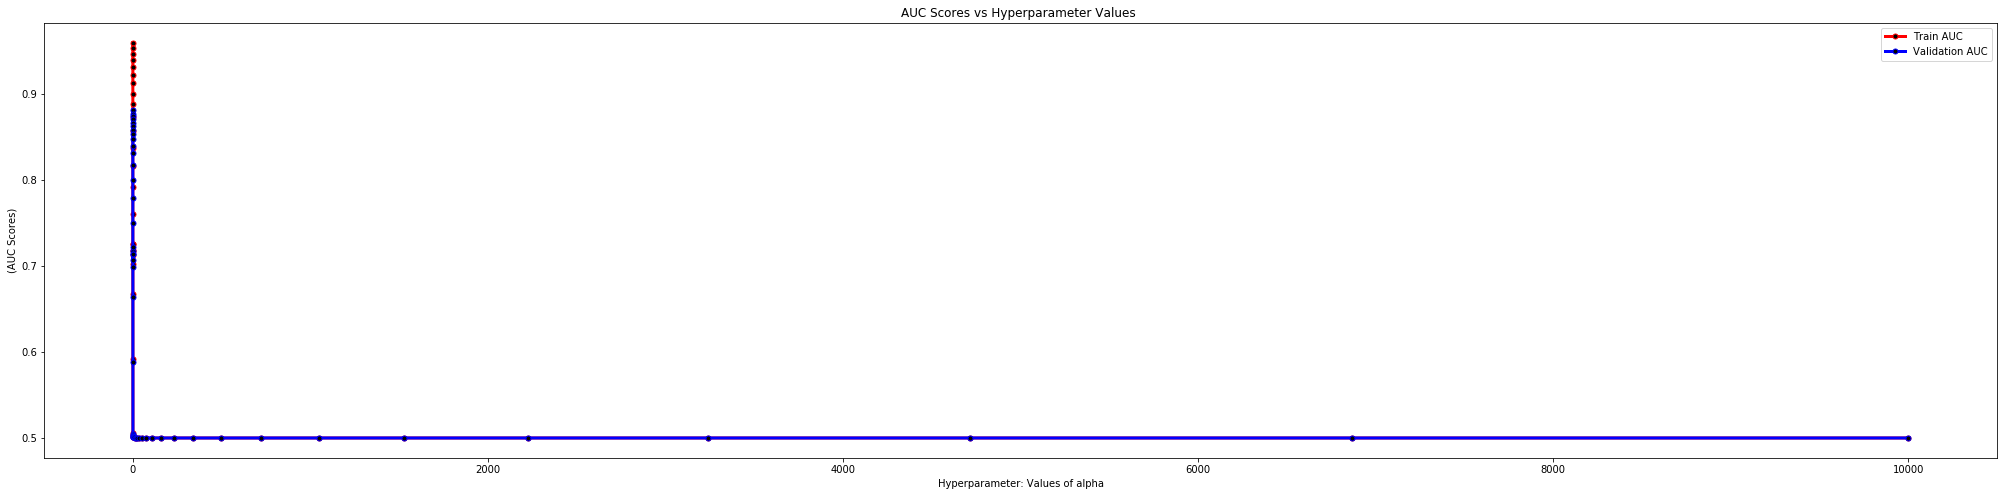

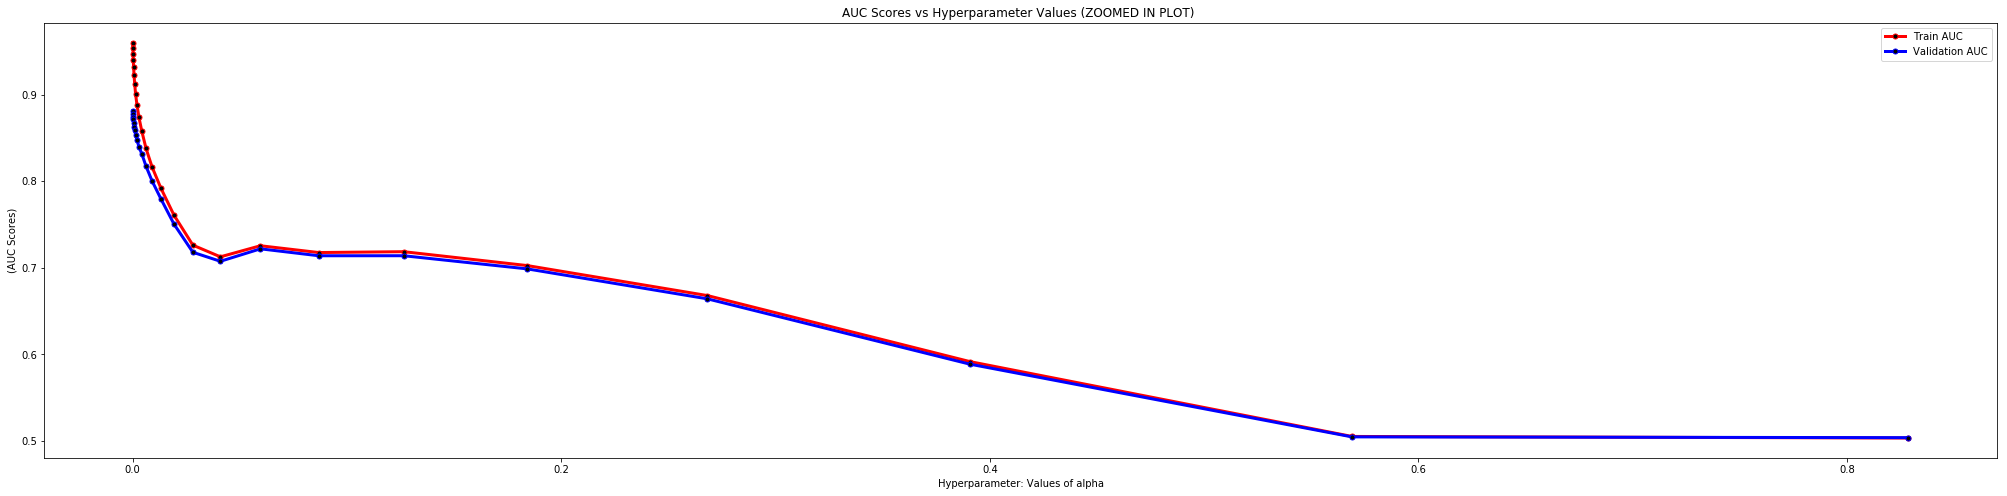


'''PERFORMANCE EVALUATION for BOW-LINEAR-SVM model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 30000 data points on unseen data for l1 regularization is 27343
Accuracy of the BOW-LINEAR-SVM model using l1 regularization on unseen data is 91.14333333333333 %
Precision of the BOW-LINEAR-SVM model using l1 regularization on unseen data is 0.9301
Recall of the BOW-LINEAR-SVM model using l1 regularization on unseen data is 0.9693
F1 score of the BOW-LINEAR-SVM model using l1 regularization on unseen data is 0.9493
AUC of the BOW-LINEAR-SVM model using l1 regularization on unseen data is 0.8915

Clasification report 
             precision    recall  f1-score   support

          0       0.76      0.57      0.65      4328
          1       0.93      0.97      0.95     25672

avg / total       0.91      0.91      0.91     30000


Of all the reviews that the model has predicted to be positive, 93.0% of t

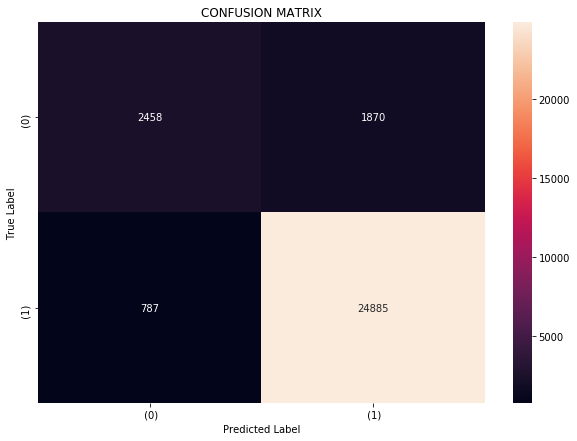

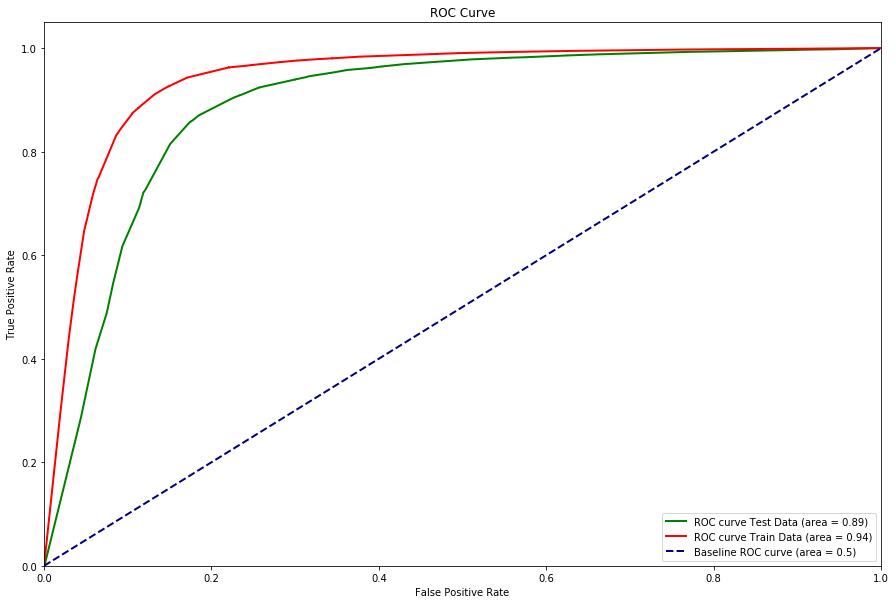

In [16]:
#Load the BOW Vectors we had created earlier and standardize them. We will standardize the train and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_BOW.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_BOW.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_BOW.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_BOW.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_BOW.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_BOW.pkl', 'rb') as file:
    y_calib = pickle.load(file)   

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, False)
X_test=standardize(X_test, False)
X_calib=standardize(X_calib, False)


#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_BOW_LSVC_L1 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', "BOW-LINEAR-SVM")

In [17]:
#Get top positive and negative features.
top_features(trained_classifier_BOW_LSVC_L1, cv_object)

The top 50 most important features from the positive class is: 

['nostril' 'great' 'hippo' 'vapor' 'hanout' 'ras' 'love' 'augment'
 'casino' 'best' 'mite' 'muscl' 'delici' 'good' 'cardboardi' 'excel'
 'luggag' 'focus' 'respiratori' 'peko' 'orbit' 'mouthwash' 'perfect'
 'austria' 'voraci' 'dilemma' 'chemist' 'subscib' 'fume' 'siberian'
 'wrist' 'paragraph' 'viabl' 'network' 'without' 'perceiv' 'plunger'
 'malamut' 'nag' 'rediscov' 'increas' 'bowser' 'yike' 'tazo' 'nice'
 'brule' 'easi' 'pickup' 'bacteria' 'paradis']

The top 50 most important features from the negative class is: 

['not' 'eruc' 'legisl' 'tragic' 'disappoint' 'uptak' 'rapese' 'citat'
 'toxicolog' 'lesion' 'murphi' 'piglet' 'journal' 'pawn' 'worst' 'westsoy'
 'rat' 'canola' 'plasma' 'ricemilk' 'aw' 'neglig' 'weakest' 'nastiest'
 'terribl' 'rob' 'retrospect' 'unfortun' 'rumor' 'telephon' 'yuck'
 'purina' 'govern' 'dishonest' 'nope' 'too' 'drab' 'tagalong' 'mosquito'
 'disgust' 'eric' 'lethal' 'wors' 'dwarf' 'circuit' 'ret

### [5.1.2] Applying Linear SVM on BOW + L2 Regularization,<font color='red'> SET 1</font>


USING L2 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l2 regularization for BOW-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:00:53.726403
Best estimator for l2 regularization : 
 SGDClassifier(alpha=0.18420699693267145, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)
Best Score for l2 regularization :  0.9335950008282417
The optimal value of C using l1 regularization is : 0.18420699693267145


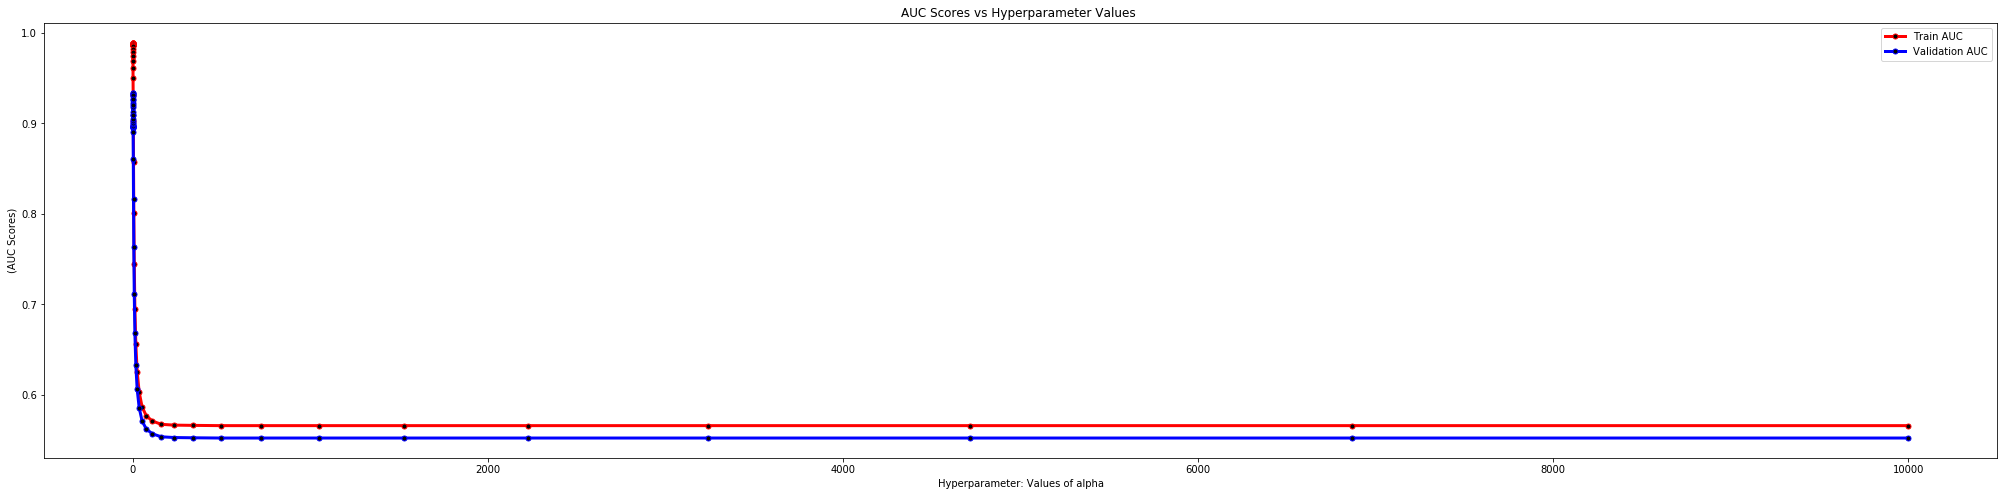

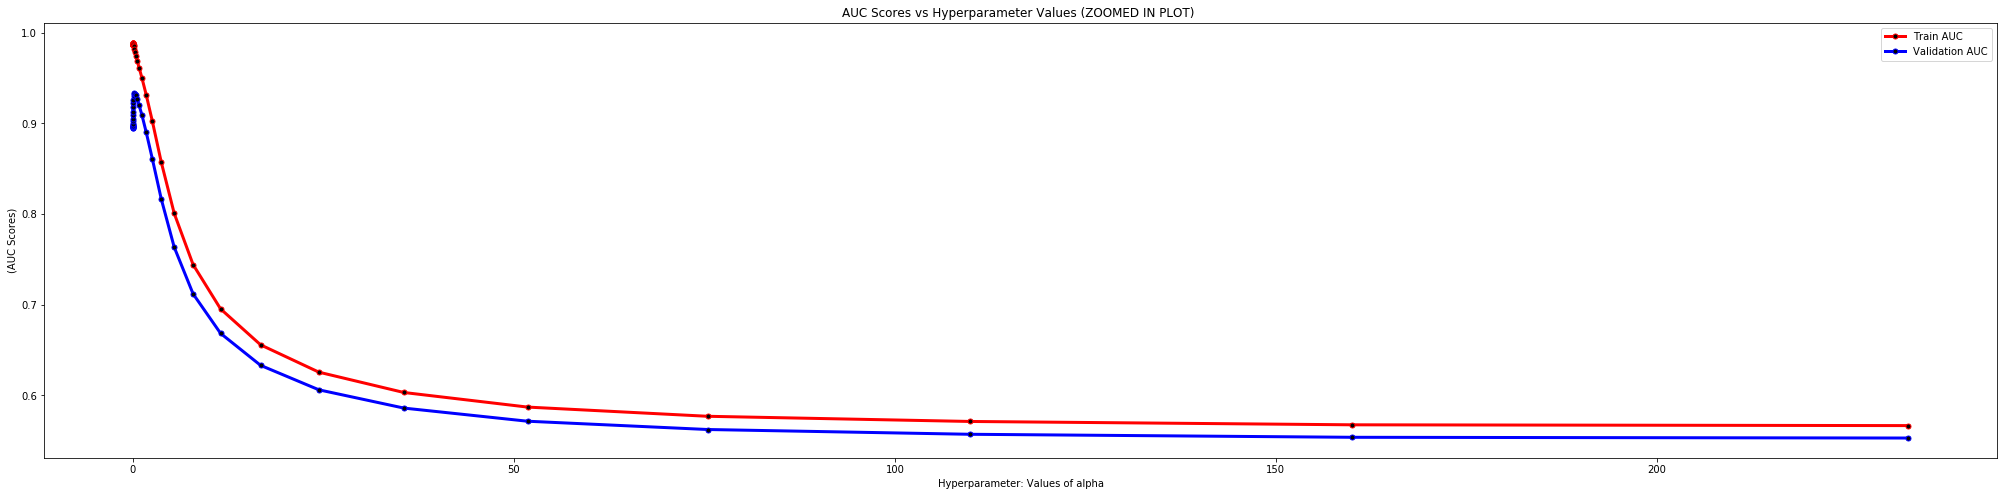


'''PERFORMANCE EVALUATION for BOW-LINEAR-SVM model using l2 regularization'''

Detailed report for Logistic regression using l2 regulaization

The number of accurate predictions out of 30000 data points on unseen data for l2 regularization is 27993
Accuracy of the BOW-LINEAR-SVM model using l2 regularization on unseen data is 93.31 %
Precision of the BOW-LINEAR-SVM model using l2 regularization on unseen data is 0.9455
Recall of the BOW-LINEAR-SVM model using l2 regularization on unseen data is 0.9782
F1 score of the BOW-LINEAR-SVM model using l2 regularization on unseen data is 0.9616
AUC of the BOW-LINEAR-SVM model using l2 regularization on unseen data is 0.9405

Clasification report 
             precision    recall  f1-score   support

          0       0.84      0.67      0.74      4328
          1       0.95      0.98      0.96     25672

avg / total       0.93      0.93      0.93     30000


Of all the reviews that the model has predicted to be positive, 95.0% of them are actu

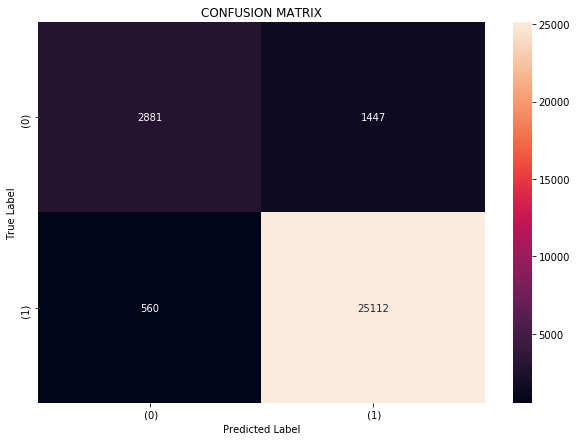

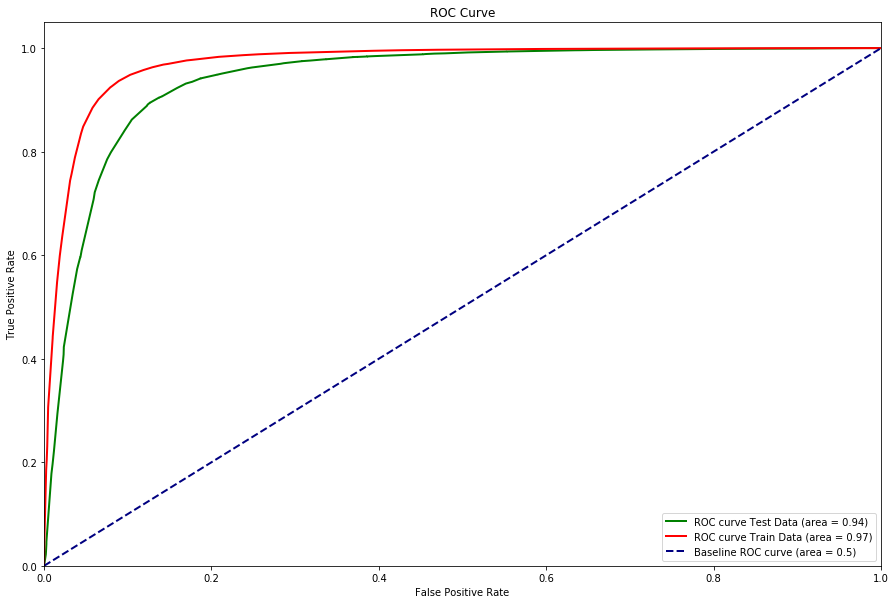

In [18]:
#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_BOW_LSVC_L2 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', "BOW-LINEAR-SVM")

In [19]:
#Get top positive and negative features.
top_features(trained_classifier_BOW_LSVC_L2, cv_object)

The top 50 most important features from the positive class is: 

['great' 'love' 'good' 'best' 'delici' 'excel' 'perfect' 'tasti' 'nice'
 'favorit' 'yummi' 'awesom' 'wonder' 'amaz' 'find' 'easi' 'thank' 'enjoy'
 'yum' 'use' 'addict' 'fantast' 'happi' 'price' 'smooth' 'littl' 'quick'
 'without' 'keep' 'store' 'well' 'work' 'definit' 'year' 'glad' 'but'
 'beat' 'recommend' 'worri' 'fresh' 'exact' 'right' 'satisfi' 'make'
 'ever' 'complaint' 'healthi' 'bit' 'fast' 'dog']

The top 50 most important features from the negative class is: 

['disappoint' 'not' 'worst' 'aw' 'horribl' 'terribl' 'yuck' 'too' 'wast'
 'did' 'bad' 'return' 'poor' 'disgust' 'money' 'stale' 'bland' 'unfortun'
 'refund' 'weak' 'threw' 'mayb' 'sorri' 'tasteless' 'thought' 'noth'
 'bewar' 'would' 'gross' 'wors' 'even' 'sad' 'nasti' 'rip' 'hope'
 'unpleas' 'lack' 'china' 'perhap' 'cancel' 'mislead' 'dissapoint' 'meh'
 'excit' 'away' 'fals' 'doe' 'where' 'expir' 'dollar']


### [5.1.3] Applying Linear SVM on TFIDF + L1 Regularization,<font color='red'> SET 2</font>

Shape of the train data matrix:  (100000, 50000)
Shape of the test data matrix:  (30000, 50000)
Shape of the calibration data matrix:  (40000, 50000)

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l1 regularization for TFIDF-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:01:21.372300
Best estimator for l1 regularization : 
 SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)
Best Score for l1 regularization :  0.8831017301903329
The optimal value of C using l1 regularization is : 0.0001


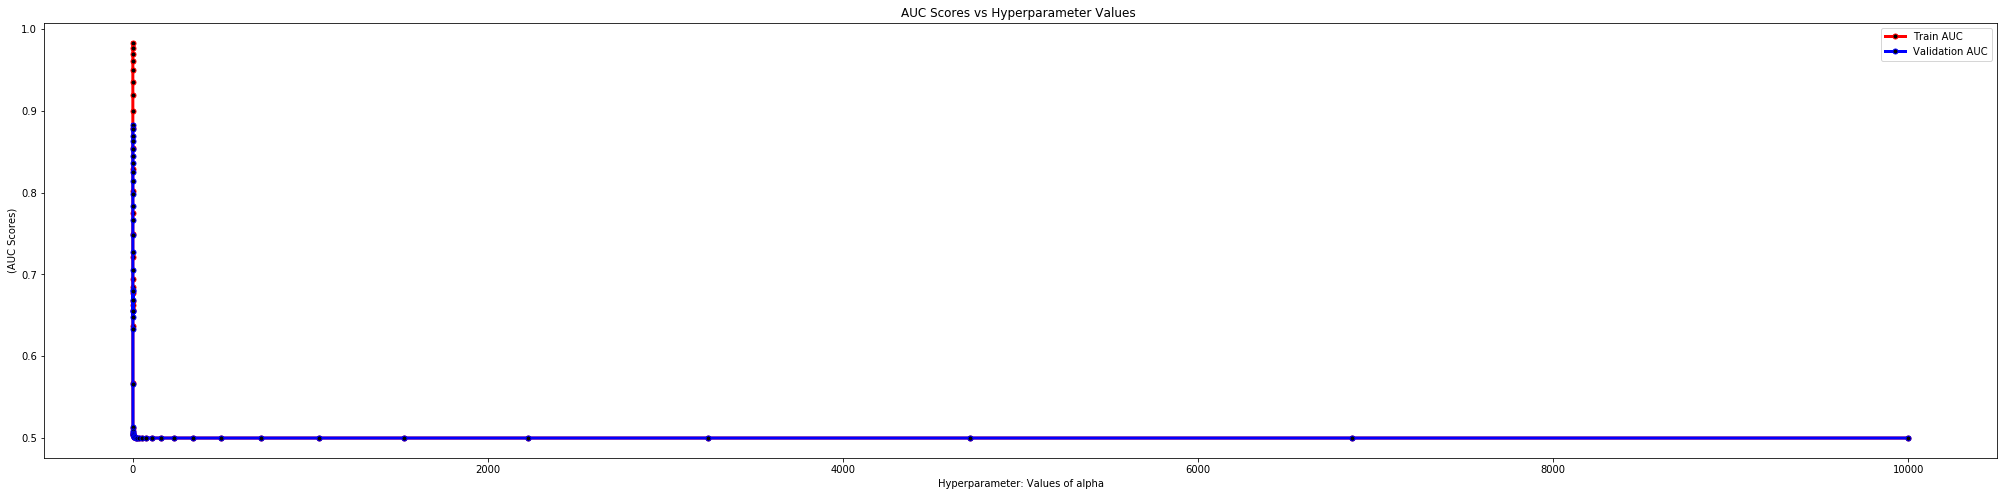

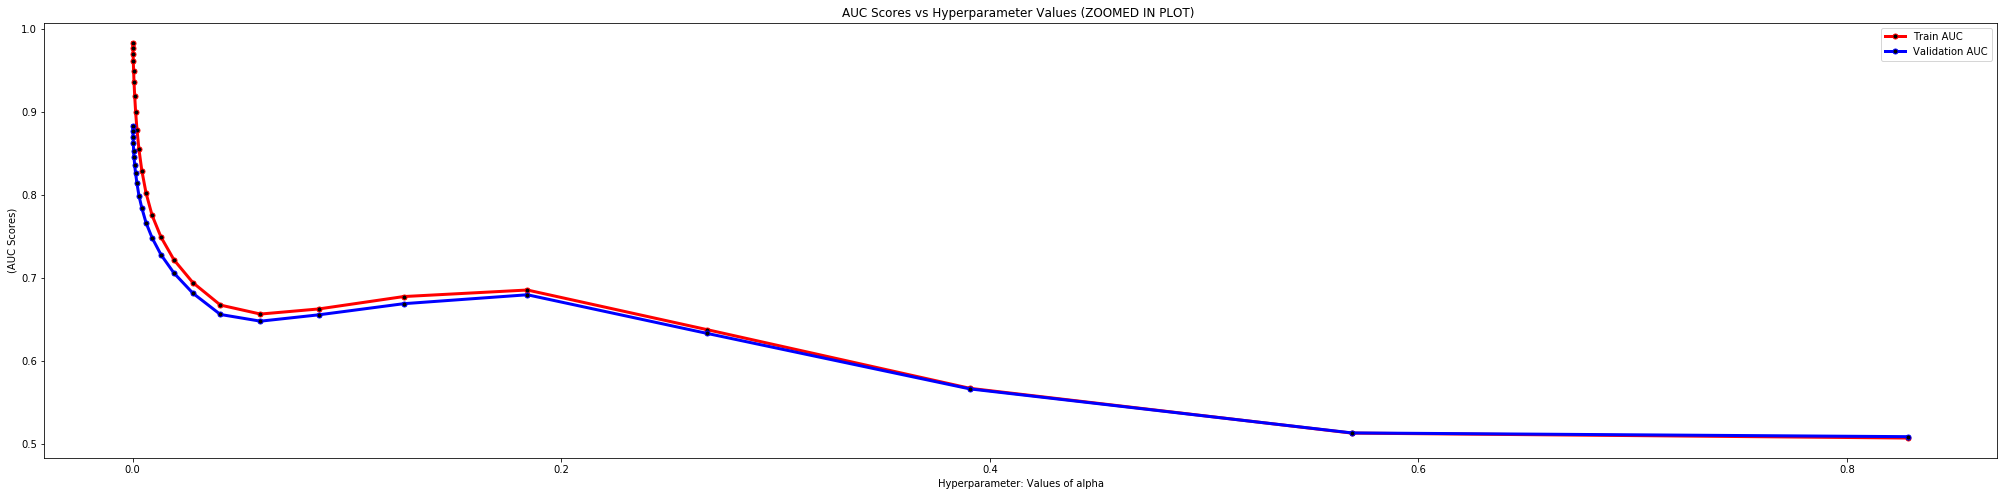


'''PERFORMANCE EVALUATION for TFIDF-LINEAR-SVM model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 30000 data points on unseen data for l1 regularization is 27313
Accuracy of the TFIDF-LINEAR-SVM model using l1 regularization on unseen data is 91.04333333333334 %
Precision of the TFIDF-LINEAR-SVM model using l1 regularization on unseen data is 0.9286
Recall of the TFIDF-LINEAR-SVM model using l1 regularization on unseen data is 0.9699
F1 score of the TFIDF-LINEAR-SVM model using l1 regularization on unseen data is 0.9488
AUC of the TFIDF-LINEAR-SVM model using l1 regularization on unseen data is 0.908

Clasification report 
             precision    recall  f1-score   support

          0       0.76      0.56      0.64      4328
          1       0.93      0.97      0.95     25672

avg / total       0.90      0.91      0.90     30000


Of all the reviews that the model has predicted to be positive,

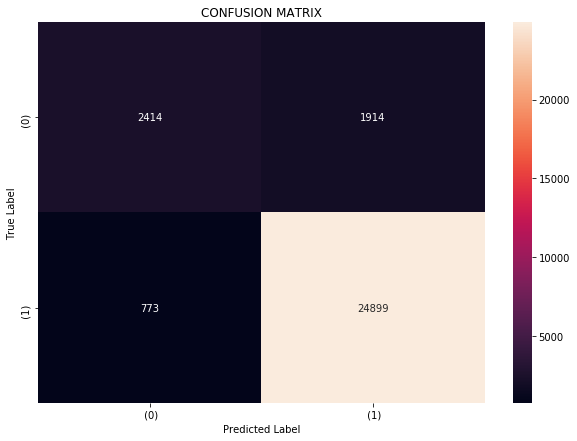

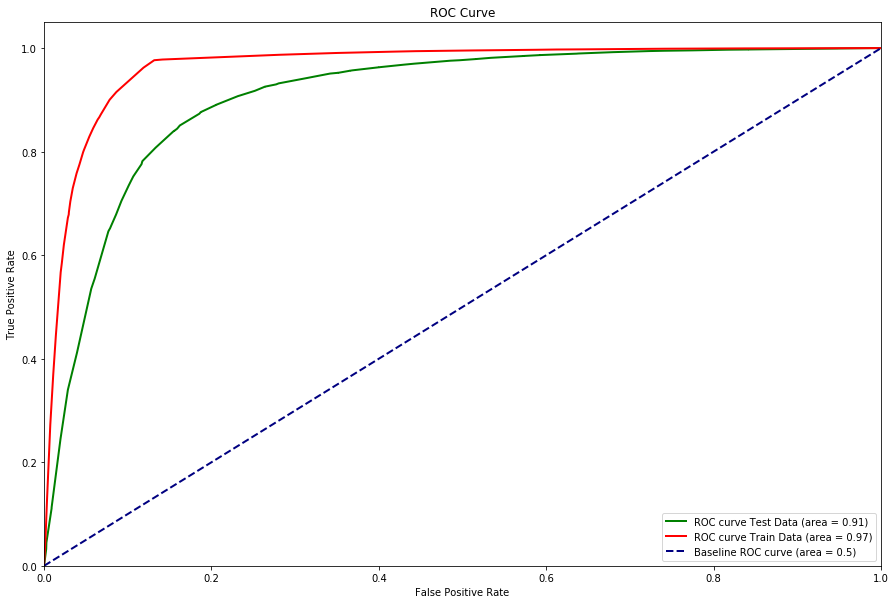

In [20]:
#Load the TF-IDF Vectors we had created earlier and standardize them. We will standardize the traina and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_TFIDF.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_TFIDF.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_TFIDF.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_TFIDF.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_TFIDF.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_TFIDF.pkl', 'rb') as file:
    y_calib = pickle.load(file)    

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, False)
X_test=standardize(X_test, False)
X_calib=standardize(X_calib, False)


#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_TFIDF_LSVC_L1 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', "TFIDF-LINEAR-SVM")

In [21]:
#Get top positive and negative features.
top_features(trained_classifier_TFIDF_LSVC_L1, tf_idf_obj)

The top 50 most important features from the positive class is: 

['great' 'love' 'amazon soon' 'teaspoon day' 'straight packag'
 'alway ship' 'ammonia' 'good' 'miss good' 'vapor' 'delici' 'pleas report'
 'delici organ' 'beani' 'brand packag' 'hard shell' 'coupon code' 'forgiv'
 'best' 'papaya' 'delici bought' 'compar purchas' 'day cook'
 'whether would' 'gritti like' 'figur might' 'love pouch' 'cook work'
 'bread gluten' 'allergi great' 'replac product' 'good addit'
 'jar contain' 'store target' 'free get' 'make smile' 'perfect'
 'accomplish' 'sugar lemon' 'that work' 'great veri' 'pit mix'
 'promis not' 'eat dairi' 'like happi' 'mite' 'institut' 'book not'
 'daili coffe' 'preserv ingredi']

The top 50 most important features from the negative class is: 

['disappoint' 'rosemari extract' 'disappoint read' 'eruc' 'eruc acid'
 'what with' 'dollar last' 'eat unless' 'not buy' 'guess stick'
 'think this' 'good name' 'not' 'ago dollar' 'never work' 'around mouth'
 'want work' 'not recommend

### [5.1.4] Applying Linear SVM on TFIDF + L2 Regularization,<font color='red'> SET 2</font>


USING L2 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l2 regularization for TFIDF-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:01:13.697518
Best estimator for l2 regularization : 
 SGDClassifier(alpha=1.7575106248547894, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)
Best Score for l2 regularization :  0.9558192970973322
The optimal value of C using l1 regularization is : 1.7575106248547894


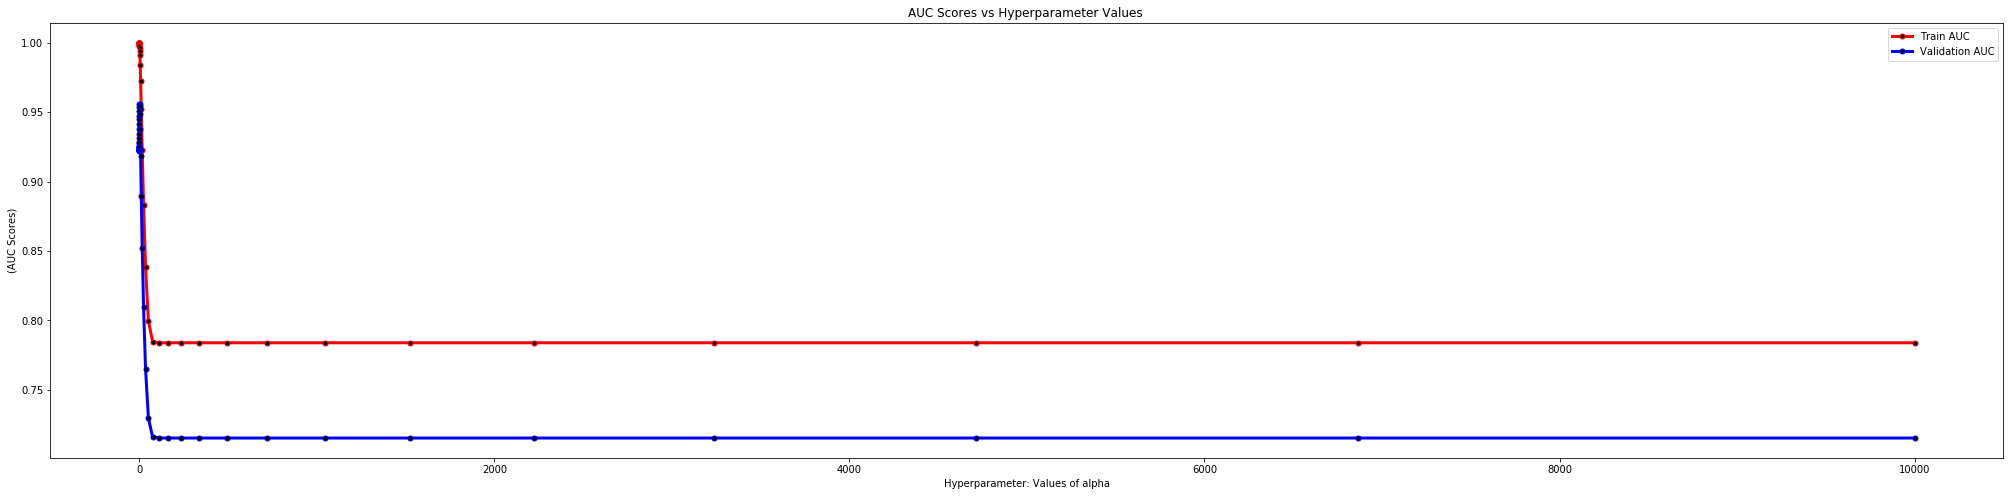

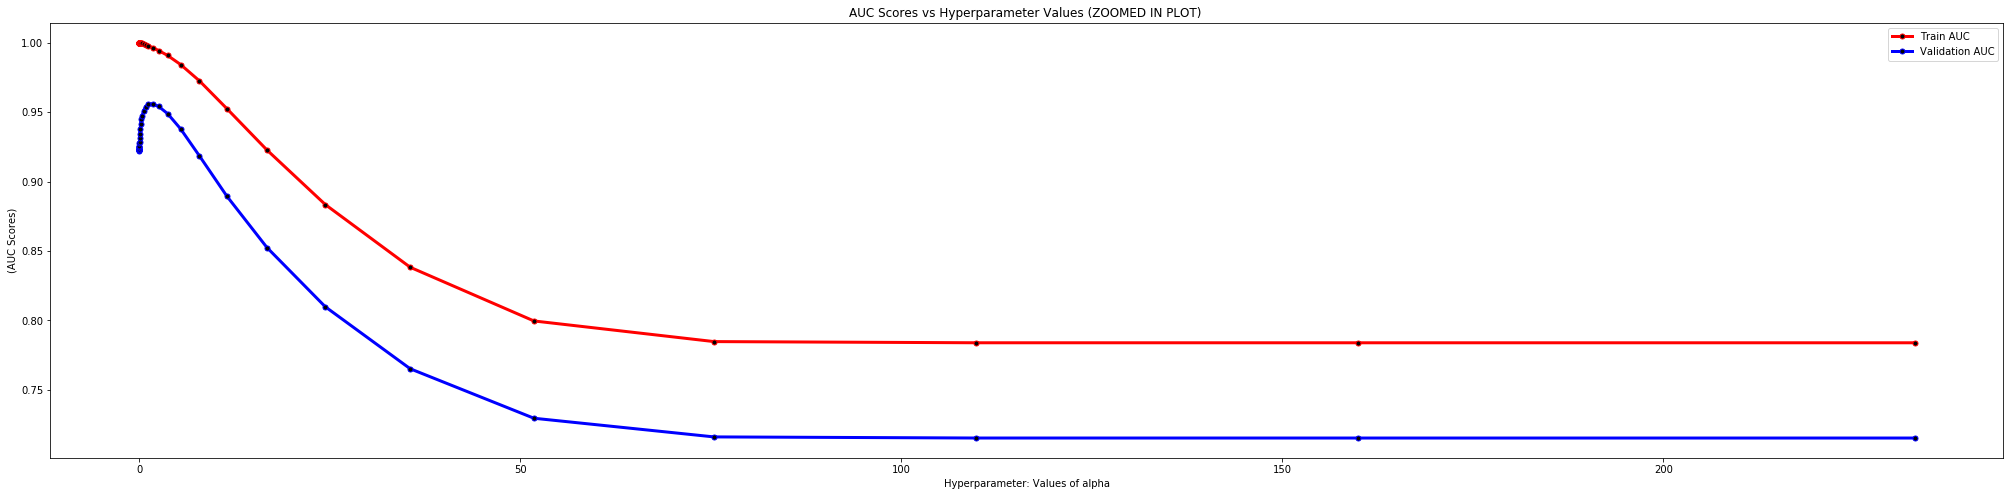


'''PERFORMANCE EVALUATION for TFIDF-LINEAR-SVM model using l2 regularization'''

Detailed report for Logistic regression using l2 regulaization

The number of accurate predictions out of 30000 data points on unseen data for l2 regularization is 28254
Accuracy of the TFIDF-LINEAR-SVM model using l2 regularization on unseen data is 94.17999999999999 %
Precision of the TFIDF-LINEAR-SVM model using l2 regularization on unseen data is 0.9547
Recall of the TFIDF-LINEAR-SVM model using l2 regularization on unseen data is 0.9784
F1 score of the TFIDF-LINEAR-SVM model using l2 regularization on unseen data is 0.9664
AUC of the TFIDF-LINEAR-SVM model using l2 regularization on unseen data is 0.9606

Clasification report 
             precision    recall  f1-score   support

          0       0.85      0.72      0.78      4328
          1       0.95      0.98      0.97     25672

avg / total       0.94      0.94      0.94     30000


Of all the reviews that the model has predicted to be positive

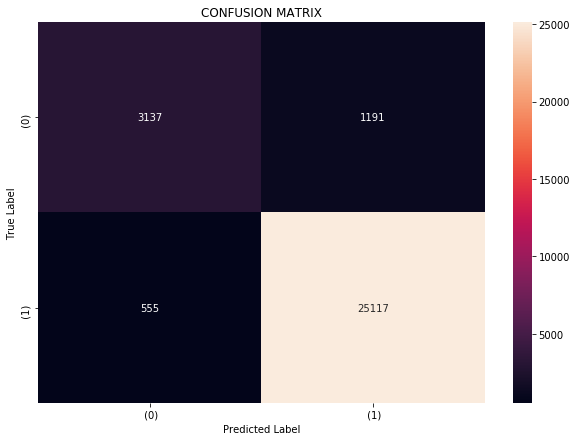

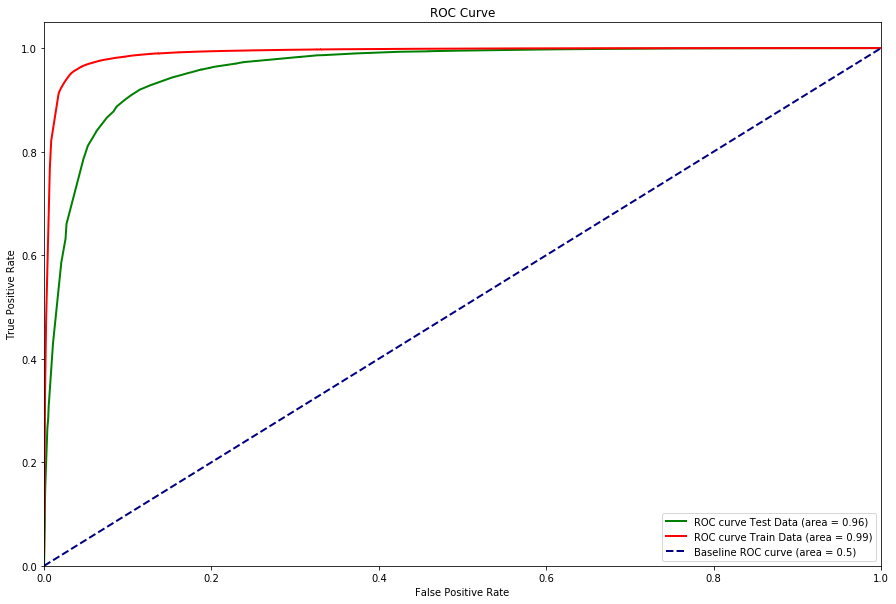

In [22]:
#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_TFIDF_LSVC_L2 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', "TFIDF-LINEAR-SVM")

In [23]:
#Get top positive and negative features.
top_features(trained_classifier_TFIDF_LSVC_L2, tf_idf_obj)

The top 50 most important features from the positive class is: 

['great' 'love' 'good' 'best' 'delici' 'excel' 'perfect' 'tasti' 'favorit'
 'yummi' 'nice' 'awesom' 'use' 'wonder' 'amaz' 'find' 'thank' 'make'
 'enjoy' 'not disappoint' 'great product' 'easi' 'happi' 'tast great'
 'yum' 'fantast' 'price' 'littl' 'without' 'addict' 'but' 'quick'
 'great tast' 'work' 'keep' 'well' 'store' 'dog love' 'high recommend'
 'fresh' 'the best' 'year' 'better' 'like' 'get' 'time' 'recommend'
 'flavor' 'alway' 'tea']

The top 50 most important features from the negative class is: 

['disappoint' 'not buy' 'worst' 'not worth' 'not good' 'aw'
 'not recommend' 'horribl' 'terribl' 'yuck' 'return' 'disgust'
 'wast money' 'wast' 'poor' 'did not' 'would not' 'stale' 'threw' 'refund'
 'bad' 'not purchas' 'not order' 'not work' 'not' 'not veri' 'not even'
 'gross' 'did' 'bland' 'nasti' 'bewar' 'two star' 'tasteless' 'too'
 'not what' 'unfortun' 'money' 'mislead' 'not impress' 'never buy'
 'not the' 'want lik

### [5.1.5]  Applying Linear SVM on AVG W2V + L1 Regularization,<font color='red'> SET 3</font>

Shape of the train data matrix:  (100000, 200)
Shape of the test data matrix:  (30000, 200)
Shape of the calibration data matrix:  (40000, 200)

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l1 regularization for W2V-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:02:27.041849
Best estimator for l1 regularization : 
 SGDClassifier(alpha=0.0006551285568595509, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)
Best Score for l1 regularization :  0.9240346851639192
The optimal value of C using l1 regularization is : 0.0006551285568595509


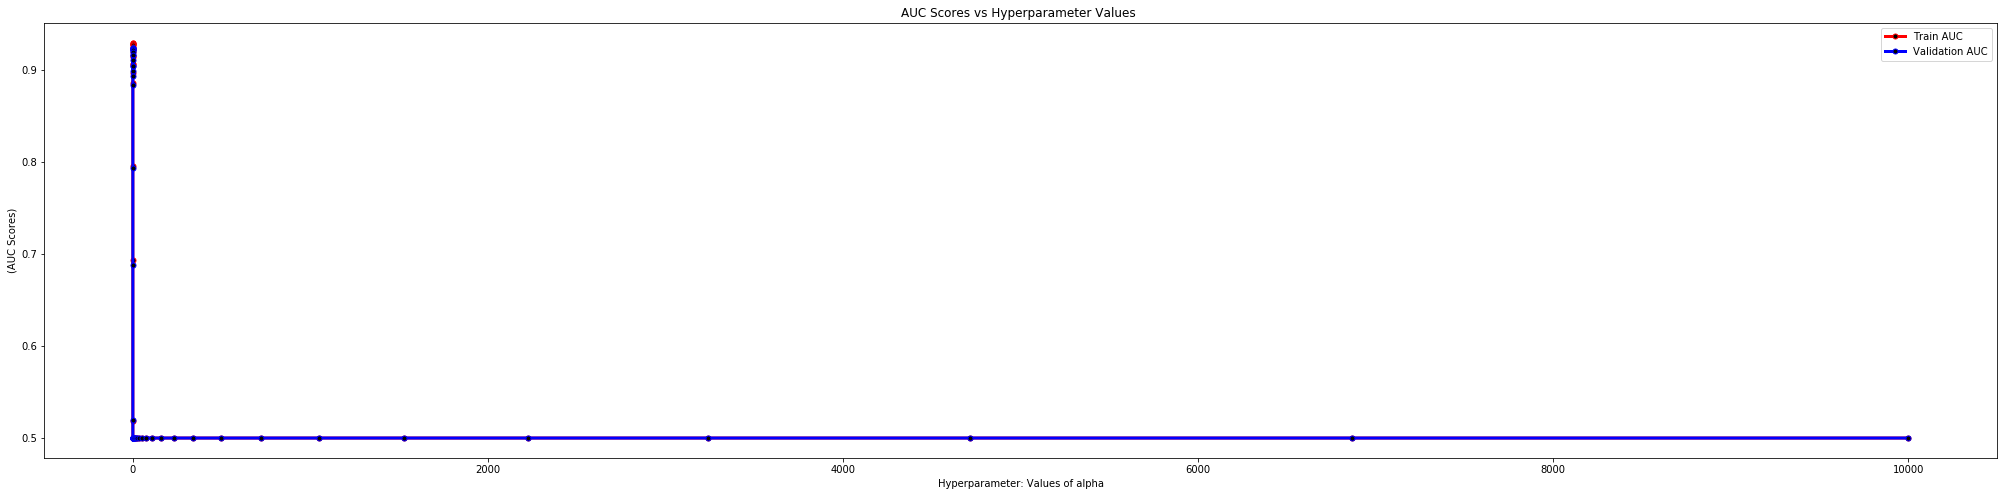

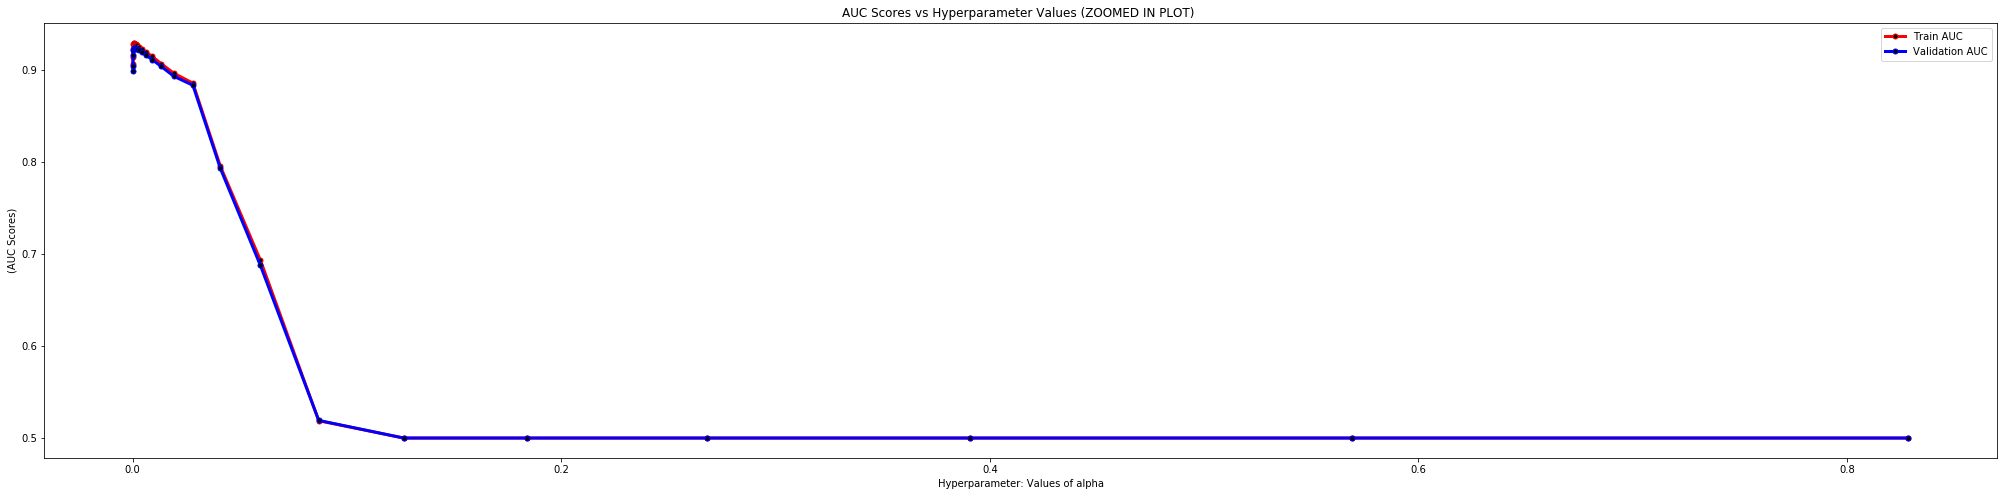


'''PERFORMANCE EVALUATION for W2V-LINEAR-SVM model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 30000 data points on unseen data for l1 regularization is 27192
Accuracy of the W2V-LINEAR-SVM model using l1 regularization on unseen data is 90.64 %
Precision of the W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.9277
Recall of the W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.9659
F1 score of the W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.9464
AUC of the W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.9248

Clasification report 
             precision    recall  f1-score   support

          0       0.73      0.55      0.63      4328
          1       0.93      0.97      0.95     25672

avg / total       0.90      0.91      0.90     30000


Of all the reviews that the model has predicted to be positive, 93.0% of them are actu

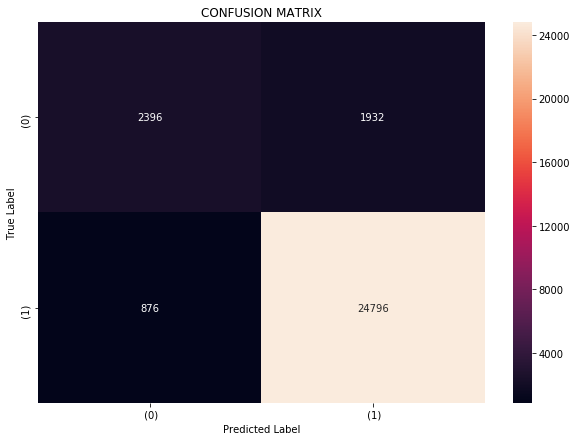

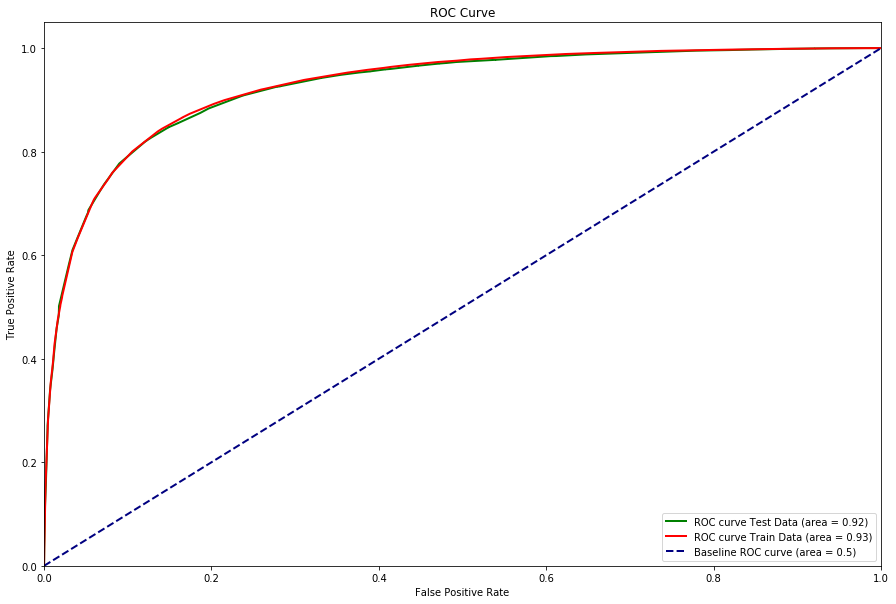

In [24]:
#Load the W2V Vectors we had created earlier and standardize them. We will standardize the traina and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_W2V.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_W2V.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_W2V.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_W2V.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_W2V.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_W2V.pkl', 'rb') as file:
    y_calib = pickle.load(file)    


print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, True)
X_test=standardize(X_test, True)
X_calib=standardize(X_calib, True)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_W2V_LSVC_L1 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', "W2V-LINEAR-SVM")

### [5.1.6]  Applying Linear SVM on AVG W2V + L2 Regularization,<font color='red'> SET 3</font>


USING L2 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l2 regularization for W2V-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:02:17.768122
Best estimator for l2 regularization : 
 SGDClassifier(alpha=0.004291934260128779, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)
Best Score for l2 regularization :  0.9254962673633781
The optimal value of C using l1 regularization is : 0.004291934260128779


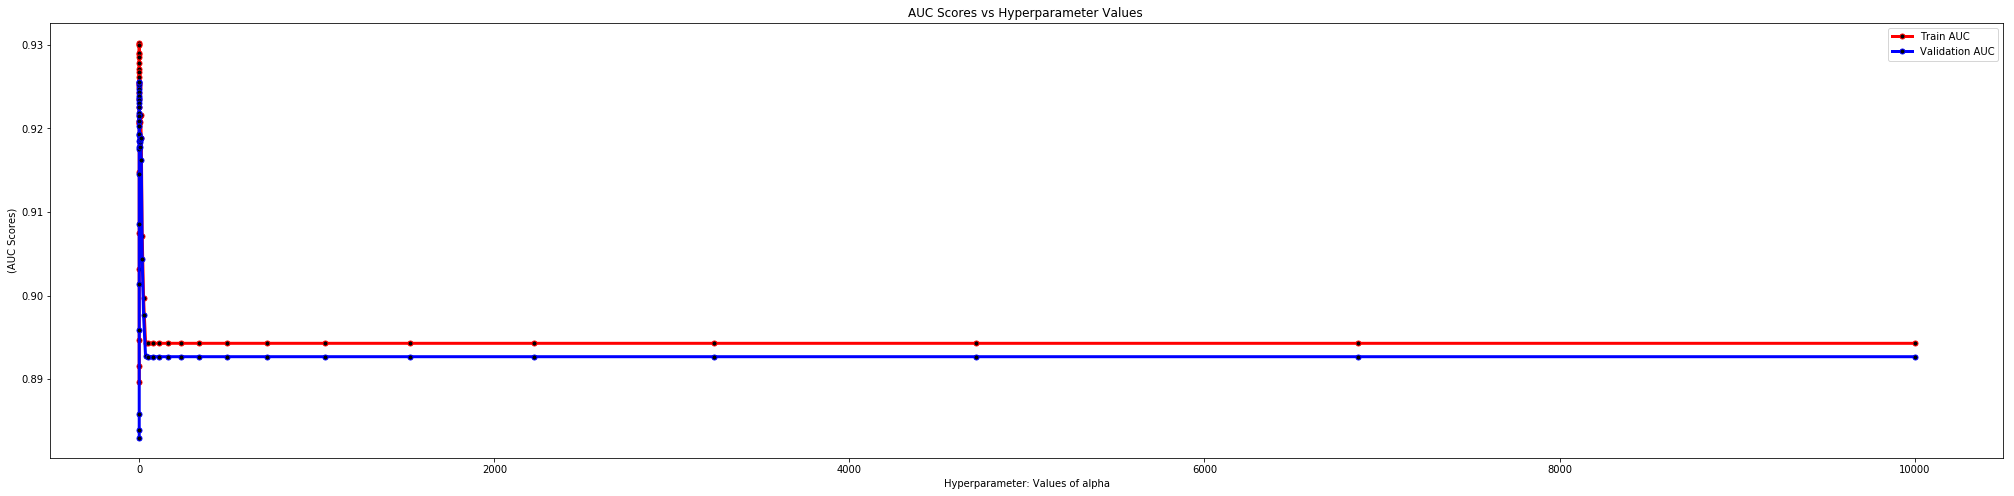

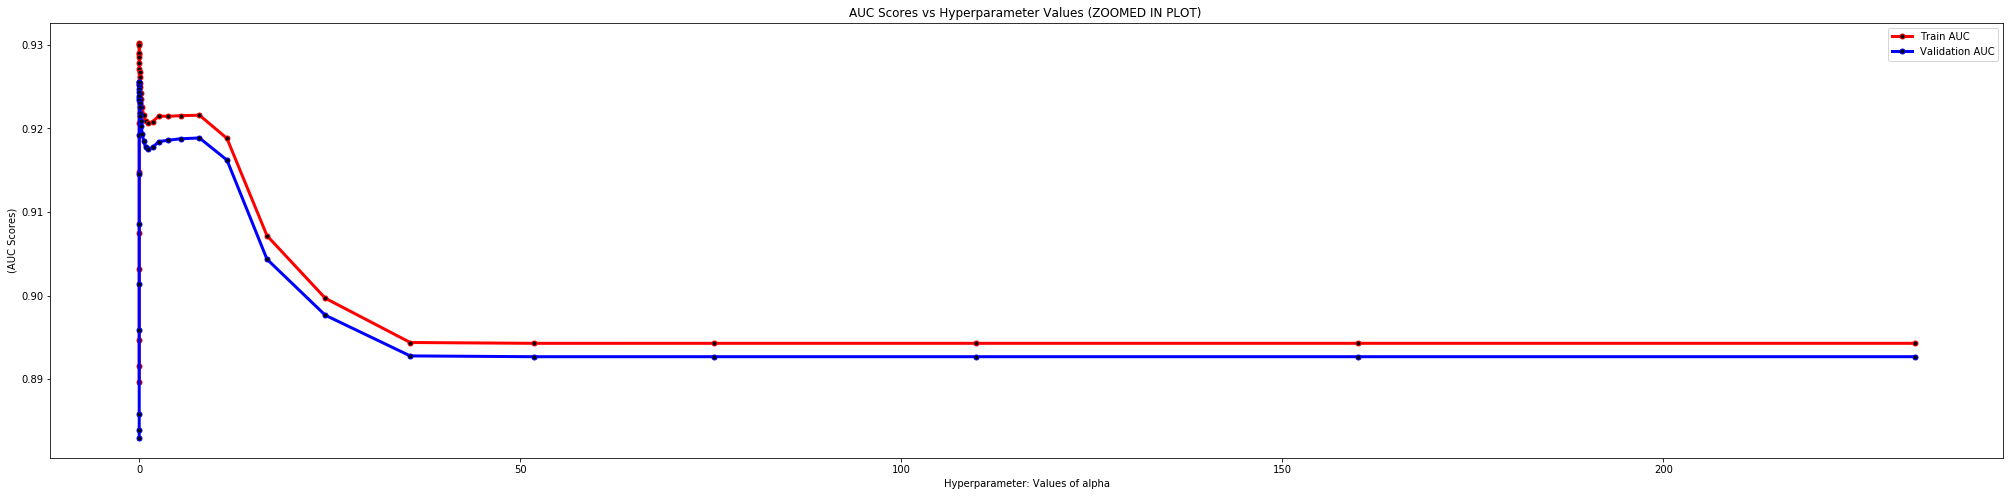


'''PERFORMANCE EVALUATION for W2V-LINEAR-SVM model using l2 regularization'''

Detailed report for Logistic regression using l2 regulaization

The number of accurate predictions out of 30000 data points on unseen data for l2 regularization is 27268
Accuracy of the W2V-LINEAR-SVM model using l2 regularization on unseen data is 90.89333333333333 %
Precision of the W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.9286
Recall of the W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.968
F1 score of the W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.9479
AUC of the W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.9281

Clasification report 
             precision    recall  f1-score   support

          0       0.75      0.56      0.64      4328
          1       0.93      0.97      0.95     25672

avg / total       0.90      0.91      0.90     30000


Of all the reviews that the model has predicted to be positive, 93.0% of th

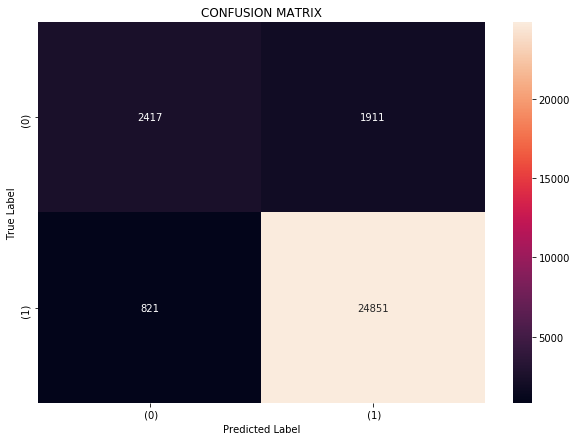

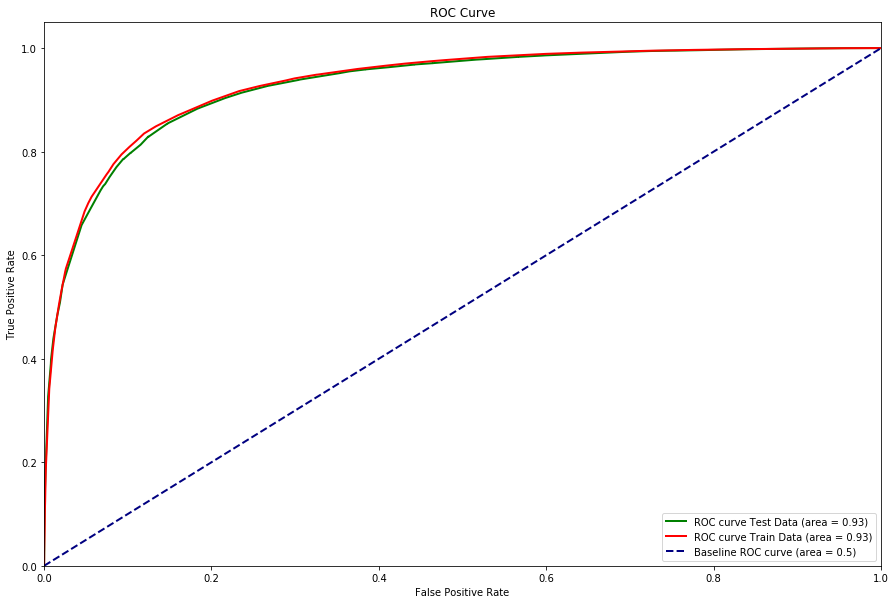

In [25]:
#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_W2V_LSVC_L2 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', "W2V-LINEAR-SVM")

### [5.1.7]  Applying Linear SVM on TFIDF W2V + L1 Regularization,<font color='red'> SET 4</font>

Shape of the train data matrix:  (100000, 200)
Shape of the test data matrix:  (30000, 200)
Shape of the calibration data matrix:  (40000, 200)

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l1 regularization for TFIDF-W2V-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:02:25.670505
Best estimator for l1 regularization : 
 SGDClassifier(alpha=0.0013894954943731374, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)
Best Score for l1 regularization :  0.8936623575777357
The optimal value of C using l1 regularization is : 0.0013894954943731374


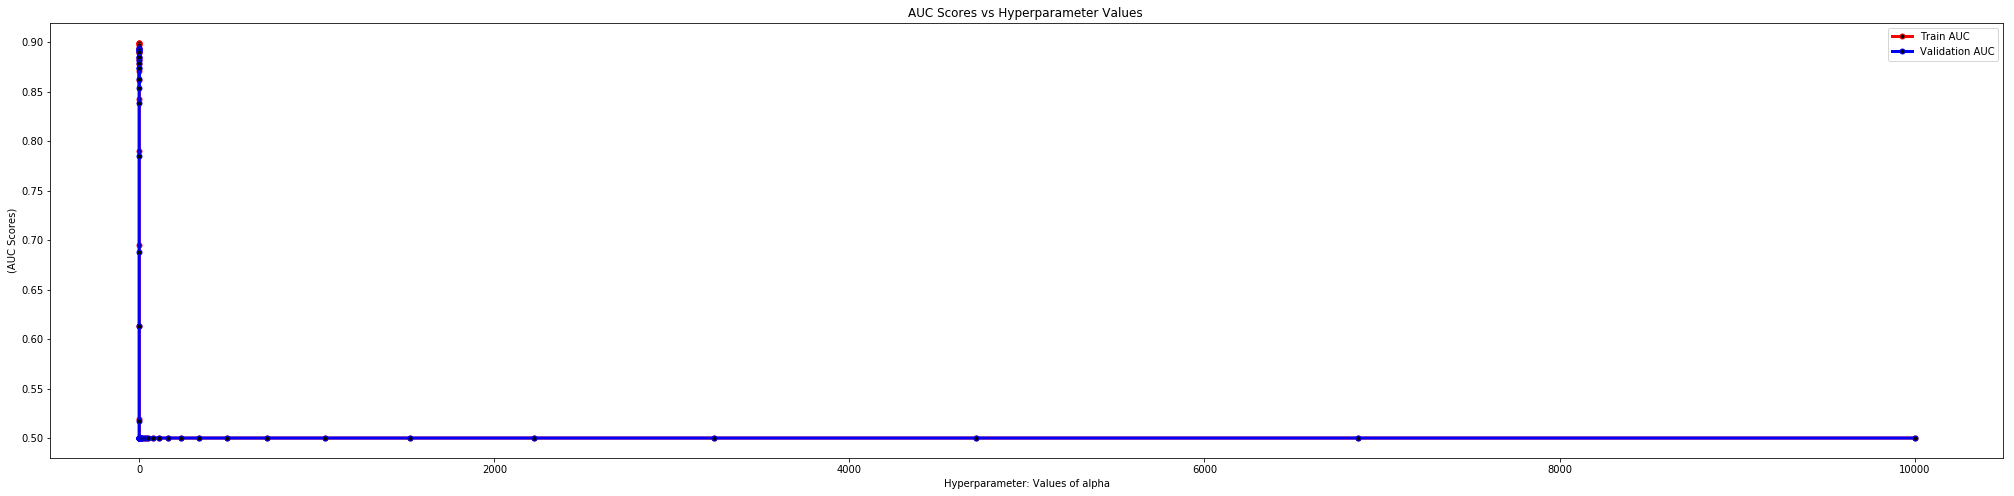

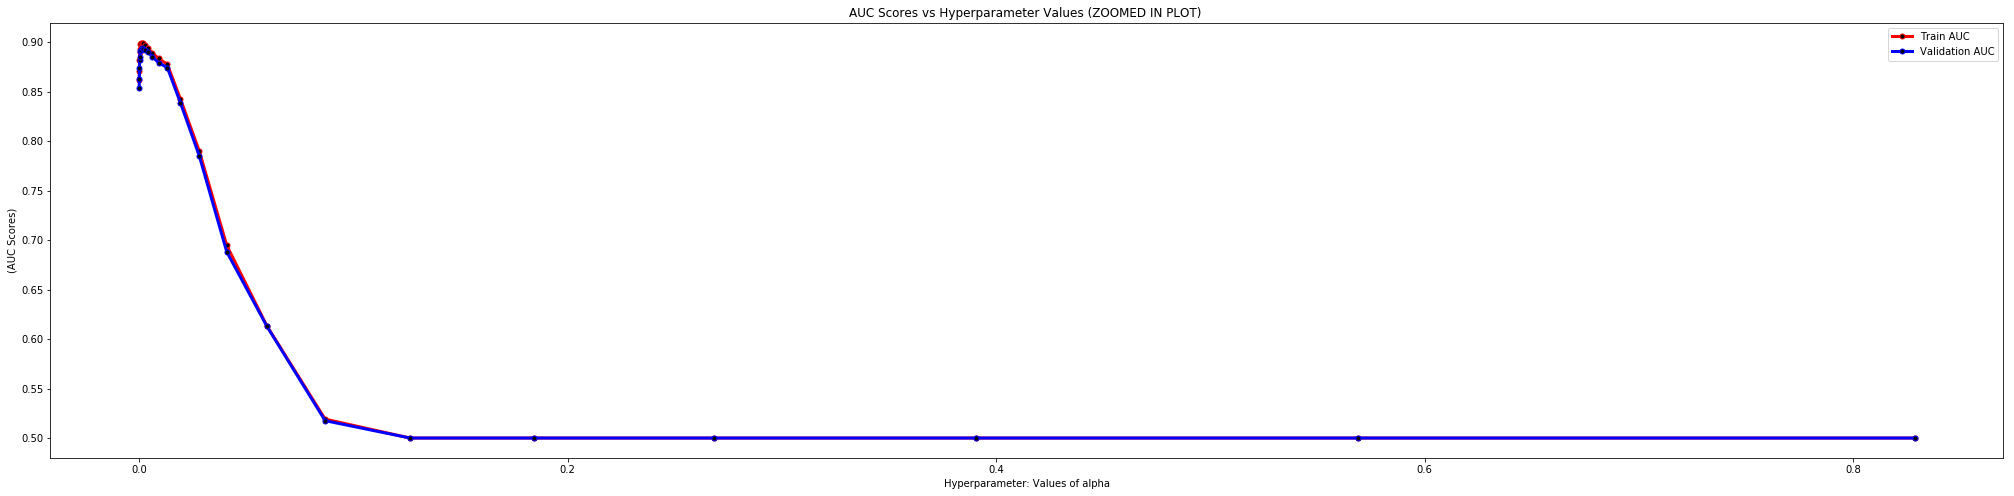


'''PERFORMANCE EVALUATION for TFIDF-W2V-LINEAR-SVM model using l1 regularization'''

Detailed report for Logistic regression using l1 regulaization

The number of accurate predictions out of 30000 data points on unseen data for l1 regularization is 26808
Accuracy of the TFIDF-W2V-LINEAR-SVM model using l1 regularization on unseen data is 89.36 %
Precision of the TFIDF-W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.9086
Recall of the TFIDF-W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.9736
F1 score of the TFIDF-W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.94
AUC of the TFIDF-W2V-LINEAR-SVM model using l1 regularization on unseen data is 0.8944

Clasification report 
             precision    recall  f1-score   support

          0       0.73      0.42      0.53      4328
          1       0.91      0.97      0.94     25672

avg / total       0.88      0.89      0.88     30000


Of all the reviews that the model has predicted to b

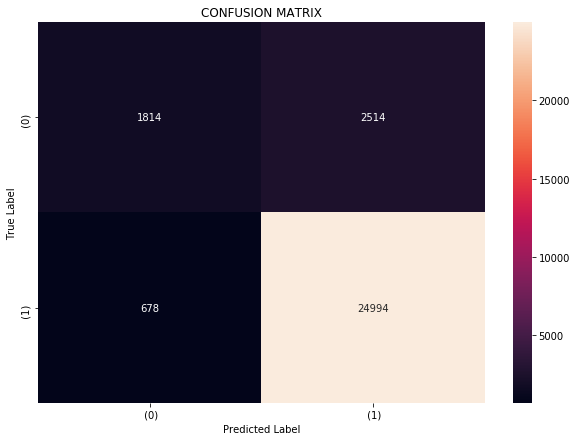

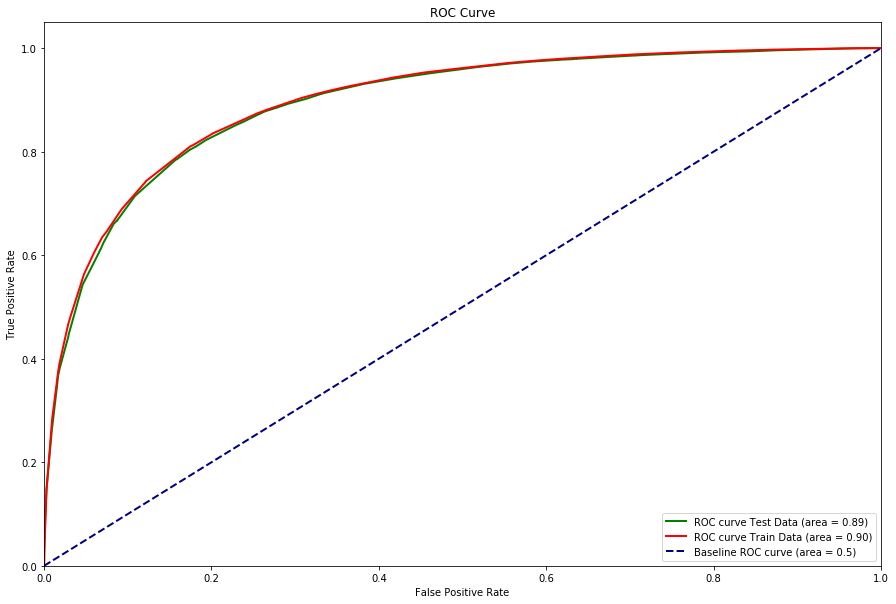

In [26]:
#Load the TF-IDF W2V Vectors we had created earlier and standardize them. We will standardize the train and test data seperately in order to prevent data leakage.
import pickle
    
with open('X_train_TFIDF-W2V.pkl', 'rb') as file:
    X_train = pickle.load(file)
with open('X_test_TFIDF-W2V.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_TFIDF-W2V.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_TFIDF-W2V.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_TFIDF-W2V.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_TFIDF-W2V.pkl', 'rb') as file:
    y_calib = pickle.load(file)    

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, True)
X_test=standardize(X_test, True)
X_calib=standardize(X_calib, True)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_W2V_LSVC_L1 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', "TFIDF-W2V-LINEAR-SVM")

### [5.1.8]  Applying Linear SVM on TFIDF W2V + L2 Regularization,<font color='red'> SET 4</font>


USING L2 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS. 
********************************************************************************

Using l2 regularization for TFIDF-W2V-LINEAR-SVM model!
*****************************************************

Time taken to perform grid search: 0:02:15.623750
Best estimator for l2 regularization : 
 SGDClassifier(alpha=0.013257113655901081, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)
Best Score for l2 regularization :  0.901783225552379
The optimal value of C using l1 regularization is : 0.013257113655901081


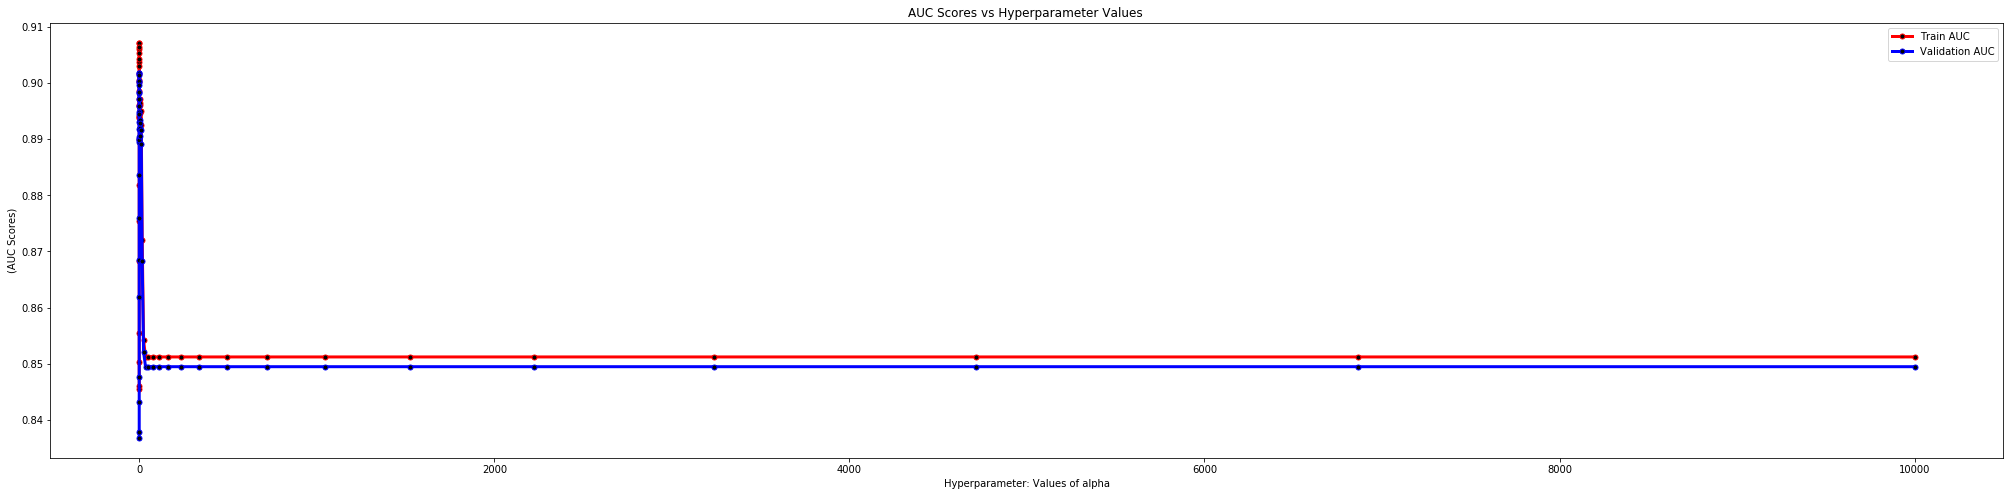

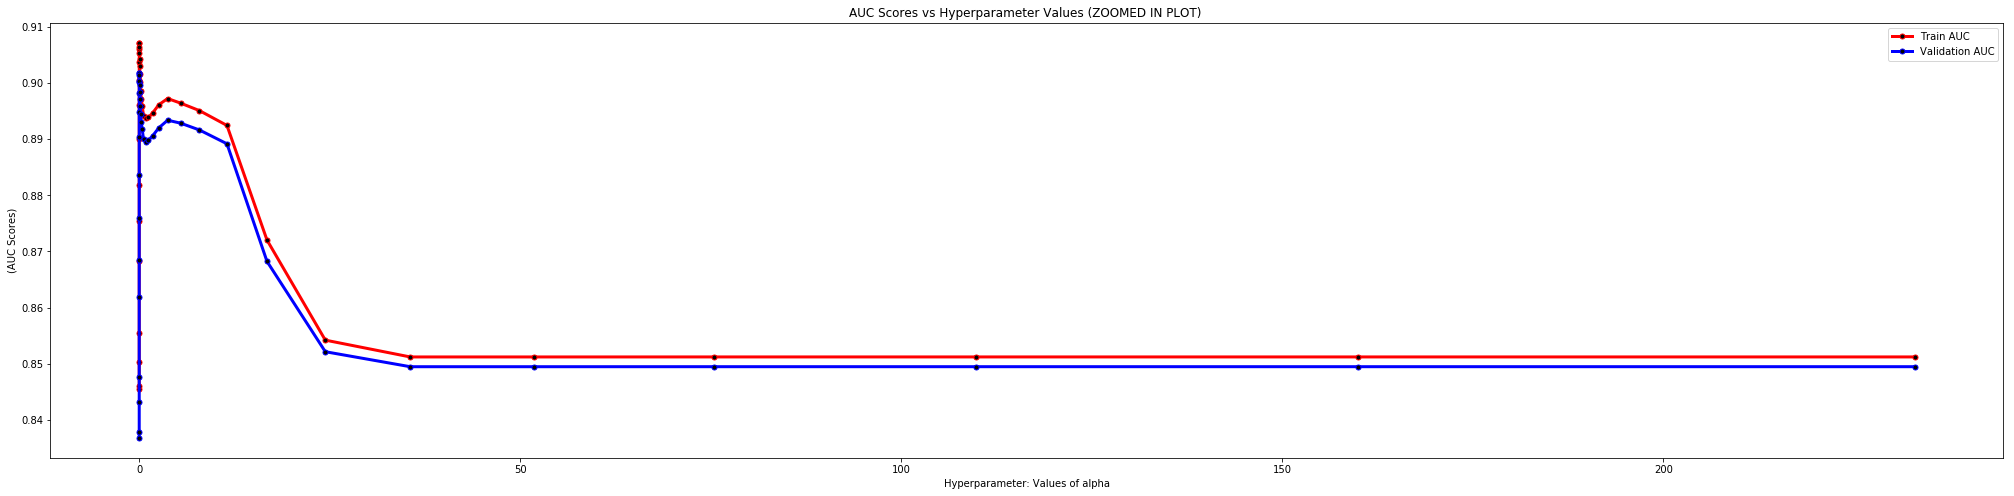


'''PERFORMANCE EVALUATION for TFIDF-W2V-LINEAR-SVM model using l2 regularization'''

Detailed report for Logistic regression using l2 regulaization

The number of accurate predictions out of 30000 data points on unseen data for l2 regularization is 26862
Accuracy of the TFIDF-W2V-LINEAR-SVM model using l2 regularization on unseen data is 89.53999999999999 %
Precision of the TFIDF-W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.9106
Recall of the TFIDF-W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.9734
F1 score of the TFIDF-W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.9409
AUC of the TFIDF-W2V-LINEAR-SVM model using l2 regularization on unseen data is 0.9041

Clasification report 
             precision    recall  f1-score   support

          0       0.73      0.43      0.54      4328
          1       0.91      0.97      0.94     25672

avg / total       0.88      0.90      0.88     30000


Of all the reviews that the model has 

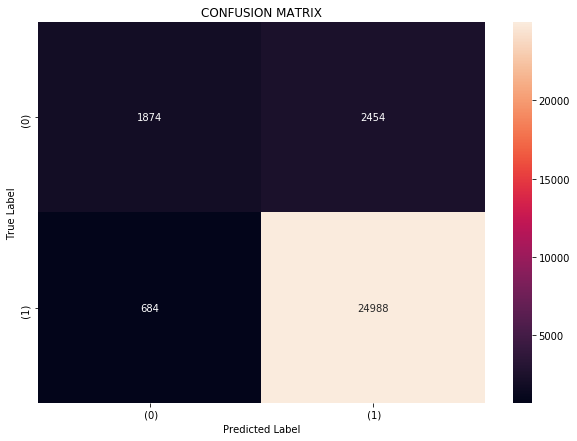

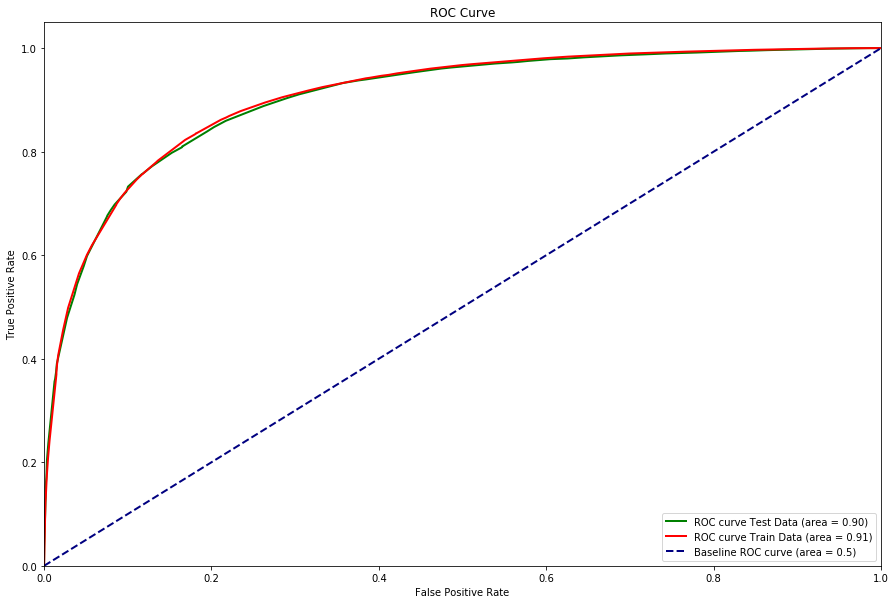

In [27]:
#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_W2V_LSVC_L2 = linear_SVM(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', "TFIDF-W2V-LINEAR-SVM")

# [6] Conclusions

In [2]:
#Compare performance and display it on a pretty table.
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", "Regularization", " Hyper-Parameter Value (C=)", "Accuracy on Unseen data", "AUC Score", "No. Of accurate predictions"]

print("Please find below the important metrics for all the models below.\n")
file = open('info_model_SVM.txt', 'r')
file.seek(0)
for line in file:
    table.add_row(line.split())
print(table)

Please find below the important metrics for all the models below.

+----------------------+----------------+-----------------------------+-------------------------+-----------+-----------------------------+
|        Model         | Regularization |  Hyper-Parameter Value (C=) | Accuracy on Unseen data | AUC Score | No. Of accurate predictions |
+----------------------+----------------+-----------------------------+-------------------------+-----------+-----------------------------+
|    BOW-LINEAR-SVM    |       l1       |            0.0001           |    91.14333333333333    |   0.8915  |            27343            |
|    BOW-LINEAR-SVM    |       l2       |            0.1842           |          93.31          |   0.9405  |            27993            |
|   TFIDF-LINEAR-SVM   |       l1       |            0.0001           |    91.04333333333334    |   0.908   |            27313            |
|   TFIDF-LINEAR-SVM   |       l2       |            1.7575           |    94.17999999999999 

As we can see from the above table, the model with the best AUC score is the linear SVM model applied on TF-IDF feature representations with L2 regularization (AUC: 0.9446, Accuracy: 93.01%). For linear SVM models, we can see that the model tends to perform better for dense data representations than sparse ones (by looking at the AUC Curve). For dense vector representations, the Train and Test AUC almost overlaps perfectly. This shows that there is no overfitting or underfitting in the models. The AUC curve for the sparse representations shows a slghtly overfitted model. The difference, however, is pretty less. The precision, recall values while predicting the positive class is fairly high as compared to the negative classes. This happens because our data is imabalanced. Balancing the dataset can help us overcome this problem if we want a high precision and recall value for the ngative class as well.